# ASV Level Running Means


Jones-Kellett et al. figs in this script:
1. Fig S1 : latitudinal trends
2. Fig S4 : spatial and temporal distances between samples
3. Fig S2 : STA methods 
4. Fig 2 : Stacked eukaryote groups
5. Fig S3 : Stacked cyanobacteria groups 

Other things in paper from this script:
- Filtered phytoplankton ASV abundance dataset
- Phytoplankton STA datasets
- Total cruise transit distance


NOTES

v3: Improved lat anom / temporal fit for ASVs with zero data

v2: Updates for paper submission; 15km definition of eddy edge


------

LJK

Date created: 07/27/25

Last edited: 08/06/25

In [2]:
import pandas as pd
import numpy as np
import datetime,math

from suntime import Sun, SunTimeException
from dateutil import tz
from datetime import timedelta
from collections import defaultdict

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.patches import ConnectionPatch

# sklearn is only installed on desktop G4 environment right now
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from config import * # directory file paths

In [3]:
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

In [4]:
data_dir = '/Users/lexijones/Dropbox (MIT)/Grad_School/Research/G4_consolidated/data/'
metadata_df = pd.read_csv(data_dir + 'AVISO_metadata_15km_near_eddy.csv',index_col=0)
metadata_df = metadata_df.set_index('sample_id')
metadata_df = metadata_df[12:]
metadata_df.head()

,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc
sample_id,,,,,,,,
16,20211120,10:54,29.0000,236.5574,0,0,0,0
17,20211120,12:44,28.7390,236.1088,0,0,0,0
18,20211120,14:43,28.5030,235.7140,0,0,0,0
19,20211121,02:03,28.2847,235.3517,0,0,0,0
20,20211121,04:04,28.0397,234.9534,0,0,0,0


## Load Phytoplankton ASV Data

- 16S for cyano
- 18S for dinoflagellates
- 16S chloroplasts for all other euks

In [5]:
pp_tax = pd.read_csv(highcov_dir + '1.20230126_G4_ASV_ID_Taxonomy_Broad_Plankton_Groups_all_phytoplankton.csv')
pp_tax.head()

,ASV_ID,Taxonomy,Broad_Plankton_Group,Phytoplankton_Broad_Group,Phytoplankton_Group
0,2f52bfb075d038a1b72a4dd9d53a01e8,Eukaryota:plas; Stramenopiles:plas; Ochrophyta...,Phytoplankton,Plastid,Dictyochophyte
1,a90268a55b92cdf24a7be460a63b6f60,Eukaryota:plas; Hacrobia:plas; Haptophyta:plas...,Phytoplankton,Plastid,Prymnesiophyte
2,3a9e3efa6d0f0df69668b602c9bac618,Eukaryota:plas; Stramenopiles:plas; Ochrophyta...,Phytoplankton,Plastid,Dictyochophyte
3,c11382dbe93c5cf9e98818644c10014b,Eukaryota:plas; Stramenopiles:plas; Ochrophyta...,Phytoplankton,Plastid,Dictyochophyte
4,34178fed607a631f7a37c6b2b70ca571,Eukaryota:plas; Stramenopiles:plas; Ochrophyta...,Phytoplankton,Plastid,Dictyochophyte


Using ASV dataset that averages the technical replicates and internal standard replicates at each sample site. The average is the most accurate estimate of abundance, as validated with concurrent flow cytometry measurements of picocyanobacteria (Jones-Kellett et al., 2024; https://doi.org/10.1093/ismeco/ycae115).

In [6]:
ASV_file = '221118-1309_LexiGradients-HighCov_2.09-fold-18S-correction_normalized_sequence_counts_abs_ASV_abundance_IS_avg_station_avg.tsv'
ASV_df = pd.read_csv(highcov_dir + ASV_file).set_index('Unnamed: 0').transpose()
ASV_df = ASV_df.rename_axis(None, axis=1) # remove weird title of index
ASV_df = ASV_df.drop(['63','65']) # drop extra sample sites not using in analysis
ASV_df = ASV_df[12:] # crop to NPSG

# Remove ASVs with 0 abundance
zero_columns = ASV_df.columns[ASV_df.eq(0).all()] # Identify columns with all zeros (many are ASVs in the CCS but not the NPSG)
print('%s ASVs with 0 abundance'%(len(zero_columns)))
ASV_df = ASV_df.drop(columns=zero_columns) # Drop the 0-columns
ASV_df.head()

4894 ASVs with 0 abundance


,e9f376c867c2a1506d5b0996f9839a20,86cd70d2450e3f44f4a7c543f53008ee,0e775fc1584ed21db02c44461c5e120e,d089e76cb77366eba904ed413876e849,1ce3b5c6d85ce967f8677e23e3e9b0be,401a67858704d406087efd35334e84e1,13eea987393ec9079bd9805404f0d4b3,0b1c2b9ed02095f223b442c9bdd35006,4b9f1fbd0c8921c969e9bf162cf1d520,4f8257e5a38397d186bc493c97412d42,...,8e59aa4a15ef9a9cbcefc144838be1bd,21f6b0681e17c680be6827266218ea55,3e22c4b0301c60e4cdeed26478828c31,9a6d0e224383355c0f24d7d17754971c,1dff7dae56fe97a9d7bf86f11b7eedd1,6726ffe0233eb1c28eac2a6e6b3ec444,5440c5a1225f28b53adce26ad76ef79b,3e38b22291d345475562a0cf231faa20,5d47d9aa394e1e4ffec632173cf7d63e,daf6f5d5d6492c130e0d457362e9273f
16,2160.087396,109890.977077,21231.737615,3579.909810,27050.273963,18764.736505,10054.954330,7394.403465,6454.688052,3872.812852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,1852.730281,120311.626496,25253.202616,3201.942377,32028.333180,21649.093806,10883.336023,7683.605683,4044.006469,4373.587008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,2399.834554,126055.848977,29229.689662,3731.266260,36938.954767,25802.257738,12877.142850,9048.165311,10781.422288,5077.770398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,3253.067950,108661.472507,25343.936322,4285.555796,33305.786823,21363.614260,12030.371481,8443.144221,1758.132343,4501.203079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,3062.851106,119863.214378,26813.604871,4437.985324,34709.367165,23875.898348,12886.711122,10417.054763,3559.023304,4936.528129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Seperate out phytoplankton ASV counts

In [7]:
phyto_IDs = list(pp_tax['ASV_ID'])
phyto_IDs_in_merged = [i for i in phyto_IDs if i in ASV_df.columns]
phyto_ASV_df = ASV_df[phyto_IDs_in_merged]
np.shape(phyto_ASV_df)

(53, 3411)

## Filter ASVs

For this analysis, we remove ASVs that:
- Have a small contribution to total gene abundance at every site (< 0.01% of gene copies)
- Are present at only a few sites (< 10)

In [8]:
def remove_low_abundance_ASVs(df,threshold):
    """
    threshold: fraction of minimum total abundance at a given site
    """
    row_sums = df.sum(axis=1) # total abundance of every sample site
    frac_df = df.div(row_sums,axis=0) # divide every column by site total; gives fractional contribution of each ASV to total abundance at that site

    # Iterate through the ASVs
    columns_below_threshold = []
    for col in frac_df.columns:
        if frac_df[col].max() < threshold: 
            columns_below_threshold.append(col)
    
    print('Number of ASVs Below Threshold: %s'%(len(columns_below_threshold)))
    print('Percent of ASVs: %s'%(round((len(columns_below_threshold)/np.shape(df)[1])*100,2)))
    
    new_df = df.drop(columns=columns_below_threshold)
    print('Number of ASVs Above Threshold: %s'%(np.shape(new_df)[1]))
    
    return new_df

In [9]:
phyto_ASV_filtered_df = remove_low_abundance_ASVs(phyto_ASV_df,0.0001) # Must contribute 0.01% of gene copies in at least one sample site
phyto_ASV_filtered_df.head()

Number of ASVs Below Threshold: 2691
Percent of ASVs: 78.89
Number of ASVs Above Threshold: 720


,2f52bfb075d038a1b72a4dd9d53a01e8,a90268a55b92cdf24a7be460a63b6f60,3a9e3efa6d0f0df69668b602c9bac618,c11382dbe93c5cf9e98818644c10014b,34178fed607a631f7a37c6b2b70ca571,33710095af4d10c80e36a6e6cb82bae3,fec340993a739ee01f6eb267e367ea53,5d9c8af2f6a20888621ccca9ee9d21c8,75549981911a6cb5fe1cdf04b9f25a59,aae534727c3716a3160ae2d66d4b01d7,...,5d3361b4338bde79f244c35f3503b852,3ea75a3aed5bb58dc3e2d54dc5242142,cd9623414a787266aae663622e820ea3,8d04abaea29f060fee883f6635c07b53,a90e9d2736fa9f6059e63816c0161167,8fc7aba95f38f8b595ab07e0910acf91,cc87fc11b72a1cf5bec6587286b09295,f1d7f5898911fe49f5afd8b85de075f9,3b5b0726c2ed3d6a799de282c6f3161f,51f8798b2308d1576aae743c86ed952f
16,1198.322306,97.652125,598.767590,537.142245,565.397233,0.0,425.903596,352.604437,109.190293,369.112575,...,0.000000,0.0,0.0,17.830885,0.0,0.0,0.0,0.0,0.0,0.000000
17,1029.852268,68.541691,740.391763,412.214875,887.270355,0.0,426.942139,452.294856,144.110659,355.508020,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
18,1257.647665,149.483792,873.409844,507.293687,972.836620,0.0,458.637054,636.146002,193.842847,329.622653,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
19,600.500913,4.175357,382.683156,365.853471,330.286119,0.0,166.844402,271.269004,191.614445,193.189918,...,26.140758,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
20,891.376501,223.279497,676.783563,316.936731,366.296042,0.0,348.780723,124.464087,103.178415,288.660573,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,25.356423


In [10]:
def remove_low_freq(df,num):
    """
    num: minimum number of samples present in 
    """
    
    nonzero_counts = df.astype(bool).sum(axis=0) # number of non-zero values in each column
    columns_to_drop = nonzero_counts[nonzero_counts < num].index # ASVs not present at minimum num of sites
    print('# of Low Freq: %s'%(len(columns_to_drop)))
    print('Percent of ASVs: %s'%((len(columns_to_drop)/np.shape(df)[1])*100))

    # Sum of the abundance of low frequency ASVs
    s = np.abs(df[columns_to_drop]).sum()
    print('Max Low Freq ASV Abundance: %s'%(df[columns_to_drop][s.sort_values(ascending=False).index[:]]).sum()[0])

    # Drop low-freq ASVs
    new_df = df.drop(columns_to_drop, axis=1)
    print('# Remaining %s'%(np.shape(new_df)[1]))
    
    return new_df

In [11]:
phyto_ASV_no_low_freq_df = remove_low_freq(phyto_ASV_filtered_df,10) # Cutoff for presence (10 sample sites)

# of Low Freq: 314
Percent of ASVs: 43.611111111111114
Max Low Freq ASV Abundance: 1740.4141714375771
# Remaining 406


Difference in total gene copy abundances after filtering the data

Max = 99.6002
Min = 98.2696


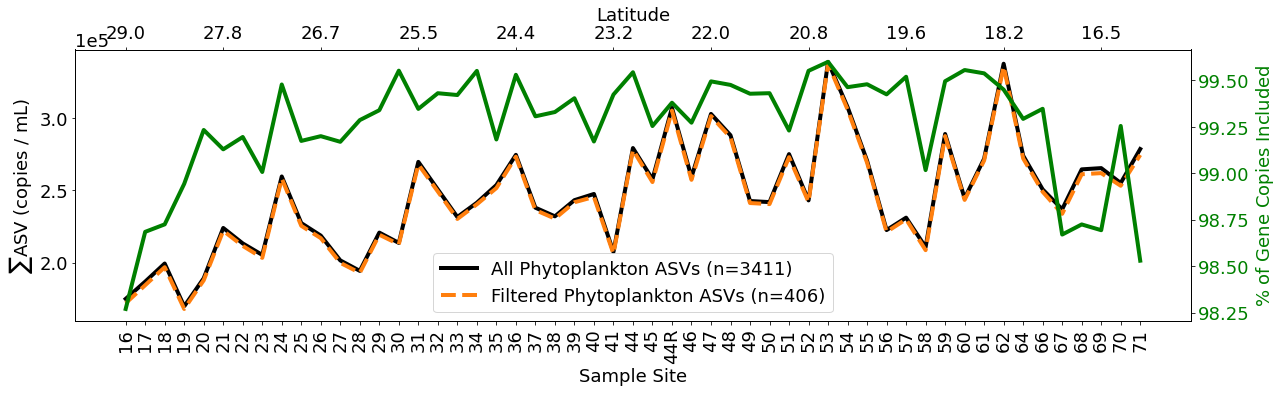

In [12]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

linewidth=4
ax.plot(phyto_ASV_df.sum(axis=1),linewidth=linewidth,
        label='All Phytoplankton ASVs (n=%s)'%(np.shape(phyto_ASV_df)[1]),c='k')
ax.plot(phyto_ASV_no_low_freq_df.sum(axis=1),linewidth=linewidth,linestyle='--',
        label='Filtered Phytoplankton ASVs (n=%s)'%(np.shape(phyto_ASV_no_low_freq_df)[1]),c='C1')

ax.set_ylabel('$\sum$ASV (copies / mL)')
ax.set_xlabel('Sample Site')
ax.legend(loc='lower center')


ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(np.arange(0,53,5))
ax_top.set_xticklabels([str(round(i,1)) for i in metadata_df.latitude][::5])
ax_top.set_xlabel('Latitude')


ax2 = ax.twinx()
perc_included = np.divide(phyto_ASV_no_low_freq_df.sum(axis=1),phyto_ASV_df.sum(axis=1))*100
print('Max = %s'%(round(np.max(perc_included),4)))
print('Min = %s'%(round(np.min(perc_included),4)))
ax2.plot(perc_included,c='green',linewidth=linewidth)
ax2.set_ylabel('$\%$ of Gene Copies Included',c='green')
ax2.tick_params(axis='y', labelcolor='green')

ax.ticklabel_format(style='sci', axis='y', scilimits=(5,5))
ax.tick_params(axis='x', rotation=90) 
plt.show()

### Phytoplankton groups in filtered ds

Filter out low freq data from pp_tax

In [13]:
filtered_tax = [i for i in pp_tax['ASV_ID'] if i in phyto_ASV_no_low_freq_df]
pp_tax = pp_tax[pp_tax['ASV_ID'].isin(filtered_tax)]
print(np.shape(pp_tax))
pp_tax.head()

(406, 5)


,ASV_ID,Taxonomy,Broad_Plankton_Group,Phytoplankton_Broad_Group,Phytoplankton_Group
0,2f52bfb075d038a1b72a4dd9d53a01e8,Eukaryota:plas; Stramenopiles:plas; Ochrophyta...,Phytoplankton,Plastid,Dictyochophyte
1,a90268a55b92cdf24a7be460a63b6f60,Eukaryota:plas; Hacrobia:plas; Haptophyta:plas...,Phytoplankton,Plastid,Prymnesiophyte
2,3a9e3efa6d0f0df69668b602c9bac618,Eukaryota:plas; Stramenopiles:plas; Ochrophyta...,Phytoplankton,Plastid,Dictyochophyte
3,c11382dbe93c5cf9e98818644c10014b,Eukaryota:plas; Stramenopiles:plas; Ochrophyta...,Phytoplankton,Plastid,Dictyochophyte
4,34178fed607a631f7a37c6b2b70ca571,Eukaryota:plas; Stramenopiles:plas; Ochrophyta...,Phytoplankton,Plastid,Dictyochophyte


In [14]:
for i in np.unique(pp_tax['Phytoplankton_Broad_Group']):
    sub_tax = pp_tax.iloc[np.where(pp_tax['Phytoplankton_Broad_Group'] == i)]['ASV_ID']
    
    # Number of ASVs by Group
    print('%s: %s ASVs'%(i,len(sub_tax)))

Cyanobacteria: 74 ASVs
Dinoflagellate: 31 ASVs
Plastid: 301 ASVs


In [15]:
euk_tax = pp_tax[pp_tax['Phytoplankton_Broad_Group'].eq('Dinoflagellate') | pp_tax['Phytoplankton_Broad_Group'].eq('Plastid')]
print(np.shape(euk_tax))
print(np.unique(euk_tax['Phytoplankton_Group']))

(332, 5)
['Chlorophyte' 'Chrysophyte' 'Cryptophyte' 'Diatom' 'Dictyochophyte'
 'Dinoflagellate' 'Pelagophyte' 'Prasinodermophyte' 'Prymnesiophyte'
 'Unknown Eukaryote Chloroplast']


In [16]:
cyan_tax = pp_tax[pp_tax['Phytoplankton_Broad_Group'].eq('Cyanobacteria')]
print(np.shape(cyan_tax))

(74, 5)


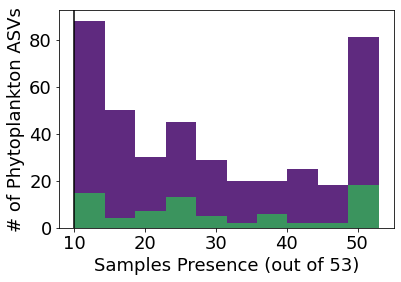

In [17]:
cyan_major_color = '#3B945E'
euk_major_color = '#5F2A7F'

cyan_nonzero = phyto_ASV_no_low_freq_df[cyan_tax['ASV_ID']].astype(bool).sum(axis=0) # num of non-zero sites for cyan
euk_nonzero = phyto_ASV_no_low_freq_df[euk_tax['ASV_ID']].astype(bool).sum(axis=0) # num of non-zero sites for euks
plt.hist([cyan_nonzero,euk_nonzero], stacked=True, 
         label=['Cyanobacteria','Eukaryotic Phytoplankton'],
         color=[cyan_major_color,euk_major_color])
plt.axvline(10,c='k')

plt.ylabel('# of Phytoplankton ASVs')
plt.xlabel('Samples Presence (out of 53)')
plt.show()

### Plot Latitudinal Trends 

Plot simplified polynomials of abundance as a function of latitude for:
- Euk / Cyan level
- Group level
- ASV level

In [18]:
groups = {}
for i in np.unique(euk_tax['Phytoplankton_Group']):
    sub_tax = euk_tax.iloc[np.where(euk_tax['Phytoplankton_Group'] == i)]['ASV_ID']
    
    # Number of ASVs by Group
    print('%s: %s ASVs'%(i,len(sub_tax)))
    
    groups[i] = phyto_ASV_no_low_freq_df.loc[:, phyto_ASV_no_low_freq_df.columns.isin(sub_tax)]

Chlorophyte: 10 ASVs
Chrysophyte: 42 ASVs
Cryptophyte: 1 ASVs
Diatom: 16 ASVs
Dictyochophyte: 29 ASVs
Dinoflagellate: 31 ASVs
Pelagophyte: 28 ASVs
Prasinodermophyte: 4 ASVs
Prymnesiophyte: 151 ASVs
Unknown Eukaryote Chloroplast: 20 ASVs


In [19]:
def leading_trailing_zeros(array):
    """Get the positions of the 0's at the beginning and end of the transect"""
    
    leading_zeros, trailing_zeros = 0,0
    for i in range(len(array)):
        if array[i] != 0:
            break
        leading_zeros += 1

    for i in range(len(array)-1, -1, -1): #iterates through the array backwards
        if array[i] != 0:
            break
        trailing_zeros += 1
        
    leading_zero_ind = leading_zeros
    trailing_zero_ind = len(array)-trailing_zeros
    
    return leading_zero_ind,trailing_zero_ind

In [20]:
def plot_lat_fits(x,y,deg):
    """
    Fit a polynomial to ASV abundance data by latitude
    """ 

    # Remove the leading and trailing zeros to do the regression
    leading_zero_ind,trailing_zero_ind = leading_trailing_zeros(y)
    cropped_y = y[leading_zero_ind:trailing_zero_ind]
    cropped_x = np.array(x[leading_zero_ind:trailing_zero_ind]).reshape(-1, 1) # needs to be 2D for scikit

    # Polynomial Regression with sklearn package (NOTE: can be finicky)
    poly_features = PolynomialFeatures(degree=deg)
    x_poly = poly_features.fit_transform(cropped_x)

    model = LinearRegression()
    model.fit(x_poly, cropped_y)

    # Get coefficients and intercept
    coefficients = model.coef_  # Coefficients (slope terms)
    intercept = model.intercept_  # Intercept (constant term)
    terms = [f"{coefficients[i]:.5f}x^{i}" for i in range(1, len(coefficients))]  # Skip x^0
    equation = f"y = {intercept:.5f} + " + " + ".join(terms)
    y_pred = model.predict(x_poly) # final model prediction

    return cropped_x, y_pred

In [21]:
color_dict = {'Picocyanobacteria':'#3B945E',
              'Diazotroph':'#f17941',
            'Prymnesiophyte':'#4056A1',
             'Dinoflagellate':'#9269b5',
             'Dictyochophyte':'#ad2713',
             'Chrysophyte':'#376E6F',
             'Unknown Eukaryote Chloroplast':'#808080',
             'Pelagophyte':'#D79922',
             'Diatom':'#E98074',
             'Chlorophyte':'#88BDBC',
             'Prasinodermophyte':'#899c75',
             'Cryptophyte':'#e6ccb3'}

In [22]:
diatom_color_shades = ['#fcebe9','#f8d7d3','#f5c2bd','#f1aea7',
                       '#ee9a91','#ea867b','#e77265','#e35d4f',
                       '#e04938','#dd3522','#c7301f','#b02a1c',
                       '#9a2518','#842015','#6e1b11','#58150e']

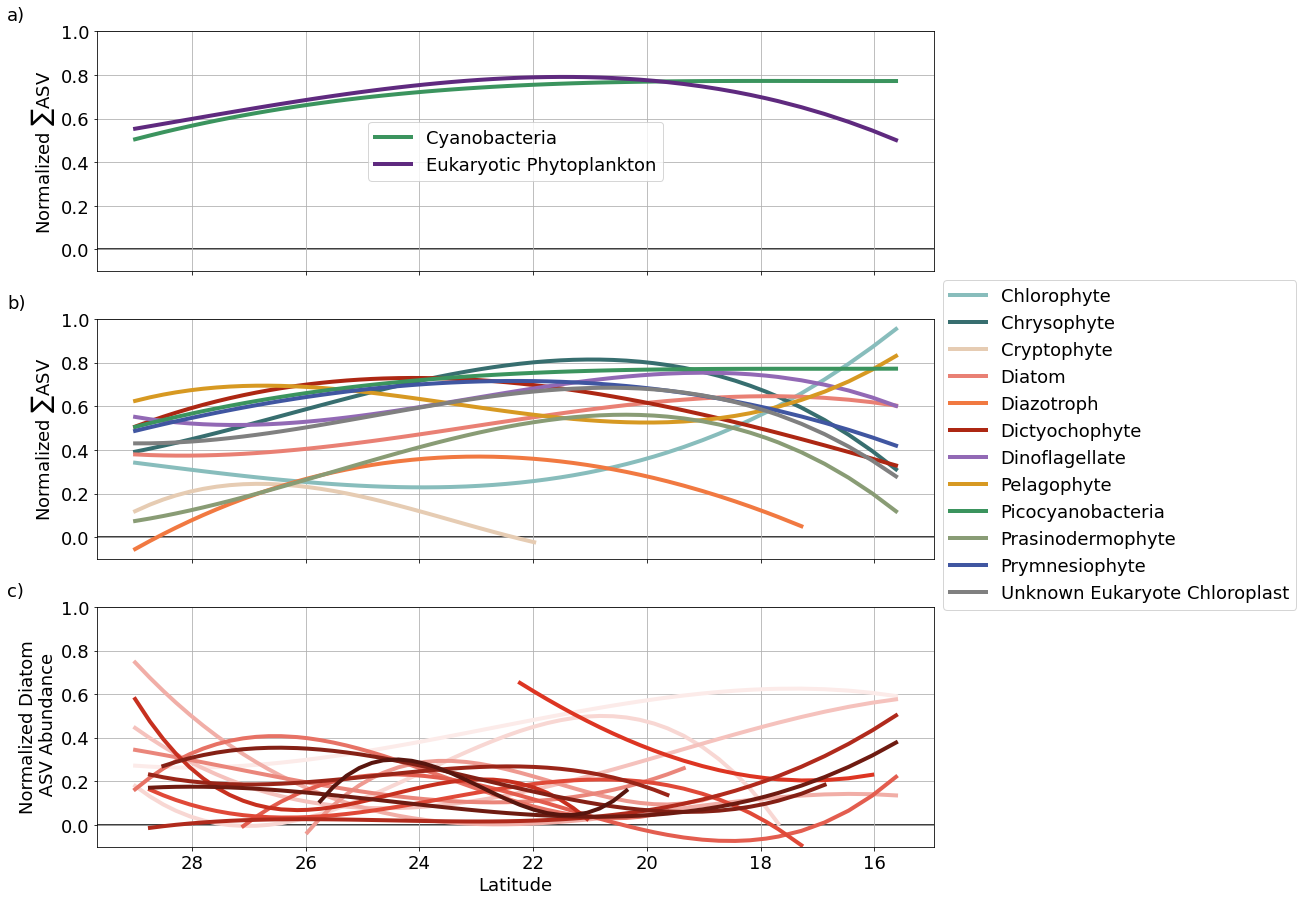

In [24]:
x = sorted(list(metadata_df.latitude))[::-1] #need to go north to south to align with sample order

fig,ax = plt.subplots(3,1,figsize=(15,15))
linewidth = 4

# Euk / cyan level
tax = [cyan_tax, euk_tax]
colors = [cyan_major_color,euk_major_color]
labels = ['Cyanobacteria', 'Eukaryotic Phytoplankton']
for t in range(2):
    group_sum = phyto_ASV_no_low_freq_df[tax[t]['ASV_ID']].sum(axis=1)
    group_sum_norm = np.divide(group_sum,np.nanmax(group_sum))# normalize by the maximum abundance    
    x_fit,y_fit = plot_lat_fits(x,group_sum_norm,3)
    ax[0].plot(x_fit,y_fit, label=labels[t], linewidth=linewidth, c=colors[t])


# Group level 
phyto_filtered_group_df = pd.DataFrame(index=metadata_df.index)
for i in np.unique(pp_tax['Phytoplankton_Group']):        
    color = color_dict[i]
    
    if i != 'Unknown Cyanobacteria': # 0 ASVs passed filter for this group
        sub_tax = pp_tax.iloc[np.where(pp_tax['Phytoplankton_Group'] == i)]['ASV_ID']
        filtered_sub_tax = [i for i in sub_tax if i in phyto_ASV_no_low_freq_df]
        
        group_sum = phyto_ASV_no_low_freq_df[filtered_sub_tax].sum(axis=1)
        phyto_filtered_group_df[i] = group_sum
        
        group_sum_norm = np.divide(group_sum,np.nanmax(group_sum))# normalize by the maximum abundance
        
        x_fit,y_fit = plot_lat_fits(x,group_sum_norm,3)
        ax[1].plot(x_fit,y_fit, label=i, linewidth=linewidth, c=color)
        
# ASV level
diatom_ASVs = pp_tax.iloc[np.where(pp_tax['Phytoplankton_Group'] == 'Diatom')]['ASV_ID']
counter = 0
for i in diatom_ASVs:
    abundance = phyto_ASV_no_low_freq_df[i]
    abundance_norm = np.divide(abundance,np.nanmax(abundance))
    x_fit,y_fit = plot_lat_fits(x,abundance_norm,3)
    ax[2].plot(x_fit,y_fit, label='Diatom %s'%(counter), linewidth=linewidth, c=diatom_color_shades[counter])
    counter += 1

for a in range(3):
    ax[a].axhline(0,c='k',zorder=1)
    ax[a].set_ylim([-0.1,1])
    ax[a].grid(True,zorder=0)
    ax[a].invert_xaxis() # north to south
    
    if a != 2:
        
        ax[a].set_xticklabels([])
        ax[a].set_ylabel('Normalized $\sum$ASV')
    else:
        ax[a].set_xlabel('Latitude')
        ax[a].set_ylabel('Normalized Diatom\n ASV Abundance')

ax[0].text(31.25,1.05,'a)')
ax[1].text(31.25,1.05,'b)')
ax[2].text(31.25,1.05,'c)')

ax[0].legend()
ax[1].legend(bbox_to_anchor=(1,1.2))

#plt.savefig(euk_paper_dir  + '/figs/supp/latitudinal_trends_supp.pdf',dpi=350, bbox_inches='tight', format='pdf')

### Save filtered abundance datasets

In [23]:
euk_ASVs = euk_tax['ASV_ID']
cyan_ASVs = cyan_tax['ASV_ID']
cyan_ASV_no_low_freq_df = phyto_ASV_no_low_freq_df[cyan_ASVs]
euk_ASV_no_low_freq_df = phyto_ASV_no_low_freq_df[euk_ASVs]

In [ ]:
#phyto_ASV_no_low_freq_df.to_csv(highcov_dir + 'abs_ASV_abundance_IS_avg_station_avg_phytoplankon_filtered.csv')
#phyto_filtered_group_df.to_csv(highcov_dir + 'group_level_abs_ASV_abundance_IS_avg_station_avg_phytoplankon_filtered.csv')
#cyan_ASV_no_low_freq_df.to_csv(highcov_dir + 'cyan_abs_ASV_abundance_IS_avg_station_avg_phytoplankon_filtered.csv')
#euk_ASV_no_low_freq_df.to_csv(highcov_dir + 'euk_abs_ASV_abundance_IS_avg_station_avg_phytoplankon_filtered.csv')

## Spatiotemporal Anomaly (STA) Pipeline

### 1. Latitudinal Fit

In [24]:
def distance_from_lat_lon(lat1,lon1,lat2,lon2):
    """
    Returns the Haversine distance in kilometers between two coordinate points. 
    Accepts negative (-180 to 180) or positive coordinate systems (0 to 360). 

    lat1,lon1: coordinates for point 1
    lat2,lon2: coordinates for point 2
    """

    R = 6371 # Radius of the earth in km
    delta_lat,delta_lon = math.radians(lat2-lat1),math.radians(lon2-lon1)
    lat1_radians,lat2_radians = math.radians(lat1),math.radians(lat2)
    
    a = math.sin(delta_lat/2) * math.sin(delta_lat/2) + math.cos(lat1_radians) * math.cos(lat2_radians) * ((math.sin(delta_lon/2))**2)
    dist = R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a)) # Distance in km
    
    return dist

In [25]:
all_dists = []

indeces = metadata_df.index
for i in np.arange(0,len(indeces)-1):
    row1 = metadata_df.loc[indeces[i]]
    row2 = metadata_df.loc[indeces[i+1]]
    all_dists.append(distance_from_lat_lon(row1.latitude,row1.longitude,row2.latitude,row2.longitude))
    
print(round(min(all_dists),2))
print(round(max(all_dists),2))
print(round(np.mean(all_dists),2))
print(round(np.median(all_dists),2))
print(round(np.sum(all_dists),2)) # total km spanned on cruise transect

28.66
56.17
45.81
46.15
2381.99


Get the rolling mean of each of the ASVs with window = 9

x--46km--x--46km--x--46km--x--46km--X--46km--x--46km--x--46km--x--46km--x

Rolling mean at each site influenced by samples collected within 46*4 = 184km distance

min_periods = 4 allows the rolling mean to still make a calculation for the beginning and end of the transect with a window size of 9

In [29]:
phyto_ASV_no_low_freq_df.min().min() 

0.0

Some ASVs have 0 abundance, which will be an issue for normalizing. Solution: Add 1 to all gene abundance

In [30]:
phyto_ASV_no_low_freq_df = phyto_ASV_no_low_freq_df+1
phyto_ASV_no_low_freq_df.min().min()

1.0

In [31]:
phyto_ASV_lat_rolling_df = phyto_ASV_no_low_freq_df.rolling(window=9,center=True,min_periods=4).mean()
print(phyto_ASV_lat_rolling_df.min().min())

0.9999999999999887


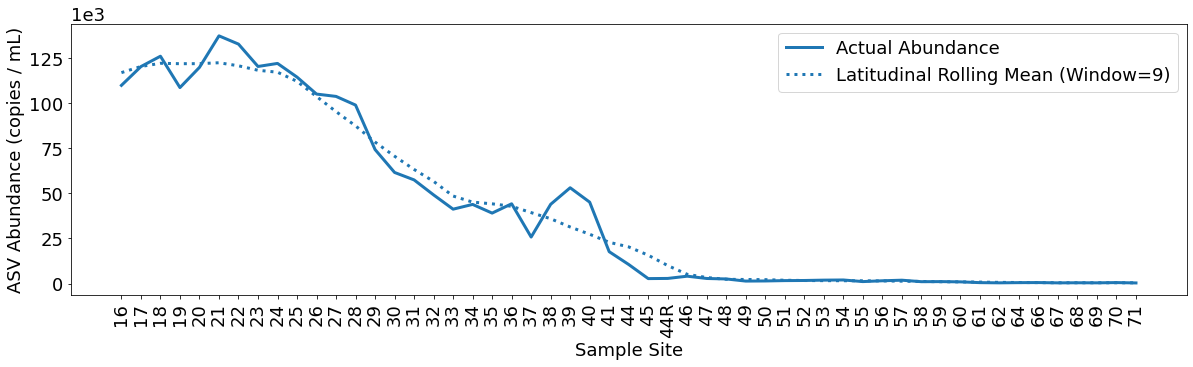

In [32]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

#ASV = '2f52bfb075d038a1b72a4dd9d53a01e8' # Example of high abundance throughout transect
#ASV = 'e9f376c867c2a1506d5b0996f9839a20' # pro HLII
ASV = '86cd70d2450e3f44f4a7c543f53008ee' # pro HLI

linewidth = 3
color = 'C0'
ax.plot(phyto_ASV_no_low_freq_df[ASV],label='Actual Abundance',linewidth=linewidth,color=color)
ax.plot(phyto_ASV_lat_rolling_df[ASV],label='Latitudinal Rolling Mean (Window=9)',
        linewidth=linewidth,linestyle=':',color=color)


# Add sci notation
pwr = 3
ax.ticklabel_format(axis='y', style='sci', scilimits=(pwr,pwr))

ax.tick_params(axis='x', rotation=90, labelsize=18)
ax.set_xlabel('Sample Site')
ax.set_ylabel('ASV Abundance (copies / mL)')

ax.legend()
plt.show()

### 2. Normalized Latitudinal Anomaly

To calculate the diel anomaly, normalizing will account for latitudinal changes in the magnitude of abundance. Otherwise, higher abundance sites will be more more likely to have a more anomalous gene count.

In [33]:
phyto_ASV_lat_anom_df = np.subtract(phyto_ASV_no_low_freq_df,phyto_ASV_lat_rolling_df) # subtract rolling mean
phyto_ASV_lat_norm_anom_df = phyto_ASV_lat_anom_df / phyto_ASV_lat_rolling_df
phyto_ASV_lat_norm_anom_df.head()

,2f52bfb075d038a1b72a4dd9d53a01e8,a90268a55b92cdf24a7be460a63b6f60,3a9e3efa6d0f0df69668b602c9bac618,c11382dbe93c5cf9e98818644c10014b,34178fed607a631f7a37c6b2b70ca571,33710095af4d10c80e36a6e6cb82bae3,fec340993a739ee01f6eb267e367ea53,5d9c8af2f6a20888621ccca9ee9d21c8,75549981911a6cb5fe1cdf04b9f25a59,aae534727c3716a3160ae2d66d4b01d7,...,8f71038498fff0c33514c4ddea1e51f5,c77b7f8f9c686383ea2b8bb57b1f1bed,dac491346912fa89ffff65876682991e,be72ca18d889c0b3c73e6ad74f34d10e,cbab111de8d072e62e59e05b16d5765b,82aba3a2486a226f16d0c8e5cf529fdc,92626f2f1d450a4b79639dc3cd43b94e,3bdb1b23136e9e81d05d89d726e4acb8,d39588a7902cf12f3af8b02b3fff16a8,f0c7ae3f06a1bed27c76d1af2fdaa4de
16,0.203486,-0.100107,-0.084893,0.254738,-0.094369,0.0,0.165061,-0.040046,-0.262385,0.200811,...,0.0,-0.951875,-0.879916,-0.907326,0.000000,2.663679,-0.347511,-0.053035,0.0,0.000000
17,0.036347,-0.469298,0.137426,-0.056980,0.452807,0.0,0.168667,0.012257,-0.133887,0.162259,...,0.0,4.714001,4.296392,-0.890815,0.000000,-0.938997,-0.957019,-0.804821,0.0,0.000000
18,0.281035,0.135505,0.381178,0.144243,0.631719,0.0,0.267789,0.320755,0.173948,0.138176,...,0.0,-0.961866,-0.839587,5.249364,-0.712185,0.621828,1.044664,-0.779465,0.0,0.000000
19,-0.378667,-0.965259,-0.383236,-0.170257,-0.443037,0.0,-0.547043,-0.512974,0.162519,-0.301003,...,0.0,-0.956654,-0.820778,-0.859532,-0.684059,-0.938521,0.506520,4.157635,0.0,0.000000
20,-0.155743,-0.309723,-0.018901,-0.366501,-0.428887,0.0,-0.091267,-0.761990,-0.435899,0.010984,...,0.0,-0.951499,-0.802793,-0.844701,-0.842288,-0.931364,1.214534,-0.733262,0.0,-0.431389


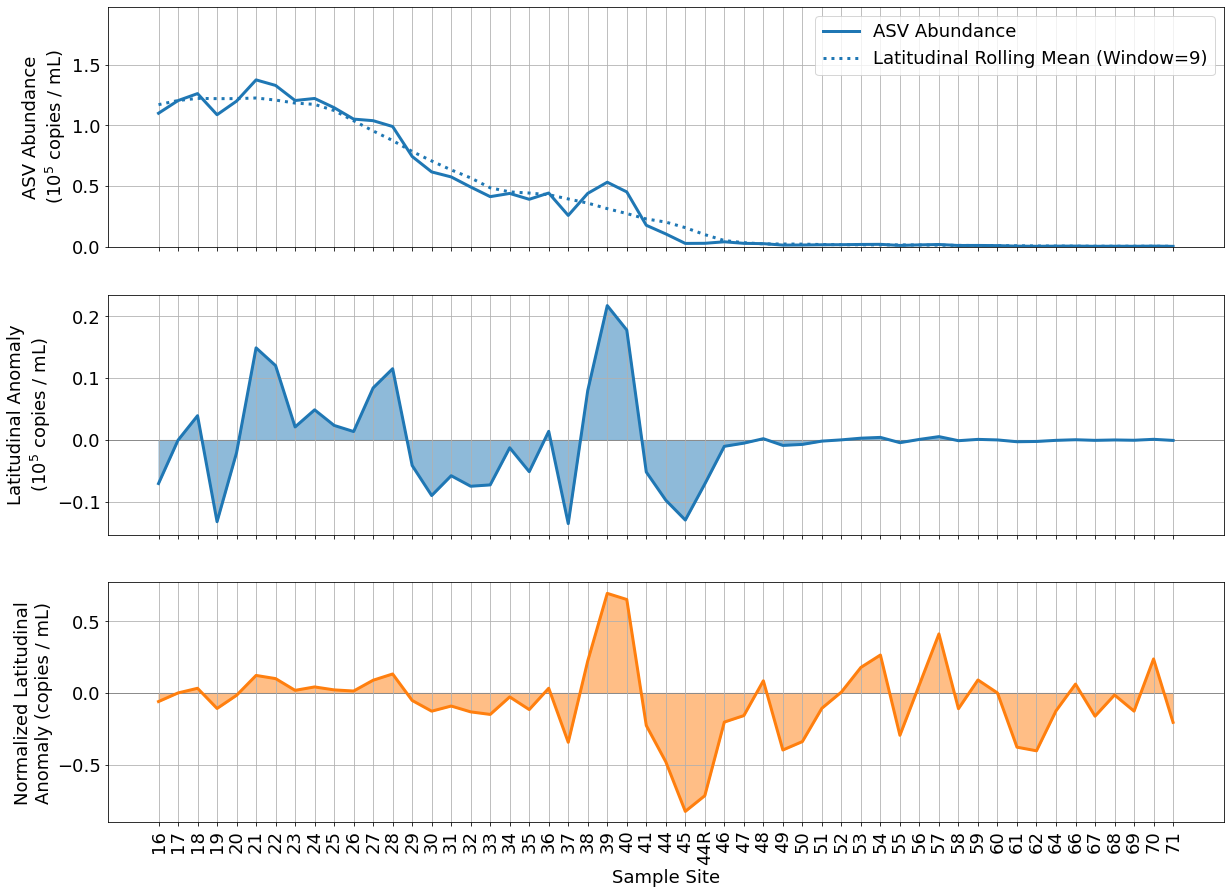

In [34]:
panels = 3
fig,ax = plt.subplots(panels,1,figsize=(20,panels*5))

linewidth = 3
ASV = '93f178a72eea5198a7d679b5c07cfd6a'
ASV = '86cd70d2450e3f44f4a7c543f53008ee'

########## Absolute abundance ##########
color0 = 'C0'
pwr0 = 5
ax[0].plot(np.divide(phyto_ASV_no_low_freq_df[ASV],10**pwr0),label='ASV Abundance',linewidth=linewidth,color=color0)
ax[0].plot(np.divide(phyto_ASV_lat_rolling_df[ASV],10**pwr0),label='Latitudinal Rolling Mean (Window=9)',
        linewidth=linewidth,linestyle=':',color=color0)
ax[0].set_xticklabels([])
ax[0].set_ylabel('ASV Abundance\n($10^%s$ copies / mL)'%(pwr0))
ax[0].set_ylim([0,max(np.divide(phyto_ASV_lat_rolling_df[ASV],10**pwr0))+0.75])
ax[0].legend()

########## Latitudinal Anomaly ##########
ax[1].plot(np.divide(phyto_ASV_lat_anom_df[ASV],10**pwr0),label='Latitudinal Anomaly',linewidth=linewidth,color=color0)
ax[1].fill_between(phyto_ASV_lat_anom_df.index,0,np.divide(phyto_ASV_lat_anom_df[ASV],10**pwr0),alpha=0.5,color=color0)

ax[1].set_ylabel('Latitudinal Anomaly\n($10^%s$ copies / mL)'%(pwr0))
ax[1].set_xticklabels([])

########## Normalized Latitudinal Anomaly ##########
color1='C1'
ax[2].plot(phyto_ASV_lat_norm_anom_df[ASV],linewidth=linewidth,color=color1)
ax[2].fill_between(phyto_ASV_lat_norm_anom_df.index,0,phyto_ASV_lat_norm_anom_df[ASV],alpha=0.5,color=color1)
ax[2].tick_params(axis ='x',rotation=90)
ax[2].set_xlabel('Sample Site')
ax[2].set_ylabel('Normalized Latitudinal\nAnomaly (copies / mL)')


for i in range(panels):
    ax[i].axhline(0,c='k',linewidth=1,zorder=1)
    ax[i].grid(zorder=0)

    
plt.show()

### 3. Temporal Fit

If there is no diel trend, this step should have little effect. If there is a trend, this should account for it. 

In [35]:
time_since_sunrise_list = [] #time since the last sunrise
time_to_sunrise_list = [] # time to closest sunrise

for row in metadata_df.iterrows():
    
    sun = Sun(row[1].latitude,row[1].longitude)
    this_day = str(row[1].date)
    this_time = str(row[1].time_UTC)
    this_datetime = datetime.datetime(int(this_day[0:4]),int(this_day[4:6]),int(this_day[6:8]),int(this_time[0:2]),int(this_time[3:5]))
    
    sunrise = sun.get_sunrise_time(this_datetime,tz.gettz('UTC'))
    
    time_since_sunrise = this_datetime - sunrise.replace(tzinfo=None) # need to remove time zone info to subtract these
    
    # if negative, add 24 hours because not yet sunrise that day
    if time_since_sunrise < timedelta(0):
        time_since_sunrise = time_since_sunrise + timedelta(hours=24)
        
    time_since_sunrise_hours = time_since_sunrise.seconds/3600 # convert to hours
    time_since_sunrise_list.append(time_since_sunrise_hours) 
    
    if time_since_sunrise_hours > 12:
        time_to_sunrise_list.append(24 - time_since_sunrise_hours)
    else: 
        time_to_sunrise_list.append(time_since_sunrise_hours)

metadata_df['time_since_sunrise'] = time_since_sunrise_list
metadata_df['time_to_sunrise'] = time_to_sunrise_list
metadata_df.head()

,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc,time_since_sunrise,time_to_sunrise
sample_id,,,,,,,,,,
16,20211120,10:54,29.0000,236.5574,0,0,0,0,20.230000,3.770000
17,20211120,12:44,28.7390,236.1088,0,0,0,0,22.033333,1.966667
18,20211120,14:43,28.5030,235.7140,0,0,0,0,0.006667,0.006667
19,20211121,02:03,28.2847,235.3517,0,0,0,0,11.300000,11.300000
20,20211121,04:04,28.0397,234.9534,0,0,0,0,13.306667,10.693333


In [36]:
metadata_sorted_df = metadata_df.sort_values(by='time_since_sunrise')
metadata_sorted_df.head()

,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc,time_since_sunrise,time_to_sunrise
sample_id,,,,,,,,,,
18,20211120,14:43,28.5030,235.7140,0,0,0,0,0.006667,0.006667
36,20211122,15:27,24.3690,228.9070,0,0,0,844202,0.380000,0.380000
37,20211122,17:22,24.1350,228.5250,0,0,844202,0,2.276667,2.276667
66,20211126,18:28,17.6862,219.8291,0,0,845344,0,2.936667,2.936667
25,20211121,18:33,26.8725,233.0058,0,0,831329,0,3.690000,3.690000


In [37]:
metadata_sorted_df.tail()

,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc,time_since_sunrise,time_to_sunrise
sample_id,,,,,,,,,,
34,20211122,11:35,24.8370,229.6620,0,0,0,0,20.553333,3.446667
24,20211121,11:53,27.0992,233.3740,0,0,0,0,21.043333,2.956667
48,20211123,13:02,21.7525,224.7086,0,0,0,0,21.743333,2.256667
17,20211120,12:44,28.7390,236.1088,0,0,0,0,22.033333,1.966667
35,20211122,13:13,24.6388,229.3400,0,0,0,0,22.166667,1.833333


In [38]:
phyto_ASV_lat_norm_anom_sorted = phyto_ASV_lat_norm_anom_df.reindex(metadata_sorted_df.index)
phyto_ASV_lat_norm_anom_sorted.head()

,2f52bfb075d038a1b72a4dd9d53a01e8,a90268a55b92cdf24a7be460a63b6f60,3a9e3efa6d0f0df69668b602c9bac618,c11382dbe93c5cf9e98818644c10014b,34178fed607a631f7a37c6b2b70ca571,33710095af4d10c80e36a6e6cb82bae3,fec340993a739ee01f6eb267e367ea53,5d9c8af2f6a20888621ccca9ee9d21c8,75549981911a6cb5fe1cdf04b9f25a59,aae534727c3716a3160ae2d66d4b01d7,...,8f71038498fff0c33514c4ddea1e51f5,c77b7f8f9c686383ea2b8bb57b1f1bed,dac491346912fa89ffff65876682991e,be72ca18d889c0b3c73e6ad74f34d10e,cbab111de8d072e62e59e05b16d5765b,82aba3a2486a226f16d0c8e5cf529fdc,92626f2f1d450a4b79639dc3cd43b94e,3bdb1b23136e9e81d05d89d726e4acb8,d39588a7902cf12f3af8b02b3fff16a8,f0c7ae3f06a1bed27c76d1af2fdaa4de
sample_id,,,,,,,,,,,,,,,,,,,,,
18,0.281035,0.135505,0.381178,0.144243,0.631719,0.000000,0.267789,0.320755,0.173948,0.138176,...,0.000000,-0.961866,-0.839587,5.249364,-0.712185,0.621828,1.044664,-0.779465,0.000000,0.000000
36,0.051003,0.049410,-0.016868,0.053663,0.085658,-0.349163,-0.046396,-0.173814,0.129362,0.024529,...,-0.969142,2.117060,-0.477223,-0.940919,-0.941731,-0.961123,-0.943653,5.227905,0.000000,-0.701635
37,0.199755,0.022237,0.207211,0.108533,0.189035,-0.638822,-0.167450,0.209129,0.128895,0.070731,...,4.414554,1.521809,1.128377,-0.921329,2.757943,-0.965245,-0.923527,-0.817128,0.000000,-0.701635
66,0.341858,-0.557685,0.188420,-0.119055,-0.720513,-0.178469,0.352170,-0.176483,0.162332,0.169970,...,1.000944,0.000000,-0.155031,-0.917668,-0.254825,6.941037,-0.869103,-0.705889,-0.941045,1.374322
25,0.200460,-0.146506,0.256634,0.005462,0.328466,0.000000,0.101877,0.226821,-0.020361,0.244748,...,0.000000,-0.946158,5.018843,2.106670,-0.889134,-0.923242,-0.741410,2.318198,0.000000,-0.689859


The latitudinal rolling mean was done on roughly equidistant samples. Here the times are not equally seperated. 

In [39]:
time_diffs = []
for i in np.arange(0,len(indeces)-1):
    row1 = metadata_sorted_df.iloc[i]
    row2 = metadata_sorted_df.iloc[i+1]
    time_diffs.append((row2.time_since_sunrise-row1.time_since_sunrise)*60)# convert to minutes
    
# Add looping difference (first and last data point)
row1 = metadata_sorted_df.iloc[0]
row2 = metadata_sorted_df.iloc[-1]
time_diffs.append(((24-row2.time_since_sunrise)+row1.time_since_sunrise)*60)
    
print(round(min(time_diffs),2))
print(round(max(time_diffs),2))
print(round(np.mean(time_diffs),2))
print(round(np.median(time_diffs),2))

2.4
113.8
27.17
22.0


Check that time_to_sunrise is the same => looks good!

In [40]:
time_diffs = []
for i in np.arange(0,len(indeces)-1):
    row1 = metadata_sorted_df.iloc[i]
    row2 = metadata_sorted_df.iloc[i+1]
    time_diffs.append(np.abs(row2.time_to_sunrise-row1.time_to_sunrise)*60)# convert to minutes
    
# Add looping difference (first and last data point)
row1 = metadata_sorted_df.iloc[0]
row2 = metadata_sorted_df.iloc[-1]
time_diffs.append(np.abs(row2.time_to_sunrise-row1.time_to_sunrise)*60)
    
print(round(min(time_diffs),2))
print(round(max(time_diffs),2))
print(round(np.mean(time_diffs),2))
print(round(np.median(time_diffs),2))

2.4
113.8
27.02
22.0


A window of 7 will learn from other samples collected within 27 min * 3 = 81 min (on average). 

In [41]:
print(round(np.std(all_dists),2))
print(round(np.std(time_diffs),2))
print(round((np.std(all_dists)/np.mean(all_dists))*100,2))
print(round((np.std(time_diffs)/np.mean(time_diffs))*100,2))

4.36
21.56
9.53
79.81


Text(0.5, 0, 'Sample Site')

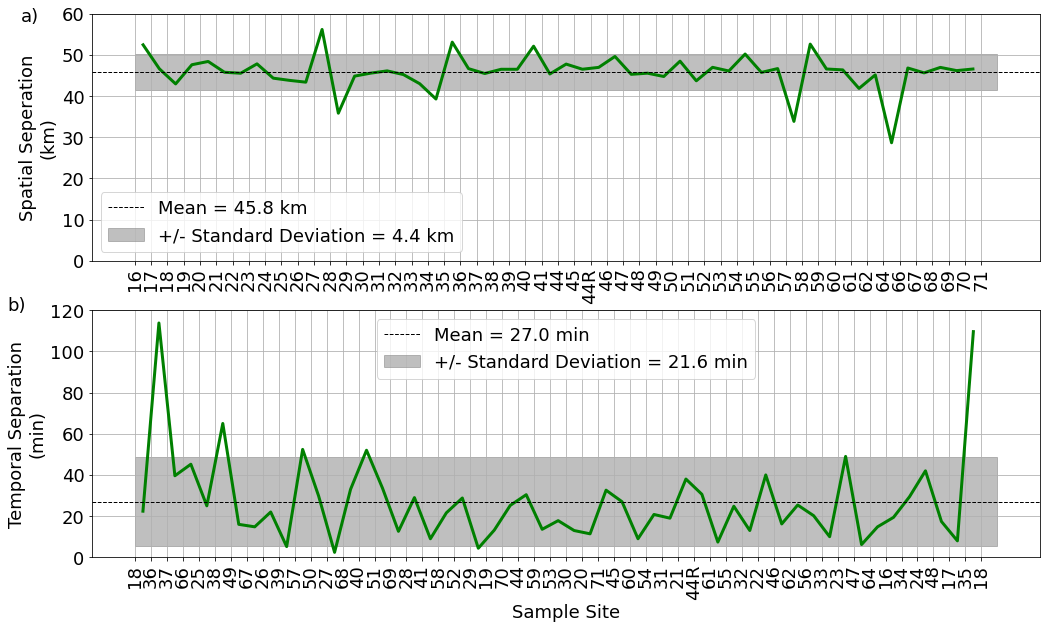

In [42]:
fig,ax = plt.subplots(2,1,figsize=(17,10))

############ SPATIAL SEPARATION ###############
ax[0].plot(np.arange(0.5,len(all_dists)),all_dists,linewidth=3,c='g')
ax[0].axhline(np.mean(all_dists),c='k',linestyle='--',linewidth=1,label='Mean = %s km'%(round(np.mean(all_dists),1)))
ax[0].fill_between([0,len(all_dists)+1],np.mean(all_dists)-np.std(all_dists),y2=np.mean(all_dists)+np.std(all_dists),
                color='gray',alpha=0.5,zorder=0,label='+/- Standard Deviation = %s km'%(round(np.std(all_dists),1)))

ax[0].set_xticks(np.arange(0,len(all_dists)+1))
ax[0].set_xticklabels(list(metadata_df.index))
ax[0].set_ylabel('Spatial Seperation\n(km)')
ax[0].text(-7,58,'a)')

############ TEMPORAL SEPARATION ###############
ax[1].plot(np.arange(0.5,len(time_diffs)),time_diffs,linewidth=3,c='g')
ax[1].axhline(np.mean(time_diffs),c='k',linestyle='--',linewidth=1,label='Mean = %s min'%(round(np.mean(time_diffs),1)))
ax[1].fill_between([0,len(time_diffs)+1],np.mean(time_diffs)-np.std(time_diffs),y2=np.mean(time_diffs)+np.std(time_diffs),
                color='gray',alpha=0.5,zorder=0,label='+/- Standard Deviation = %s min'%(round(np.std(time_diffs),1)))

ax[1].set_xticks(np.arange(0,len(time_diffs)+1))

# For the looping, add the first site to the end too
labels = list(metadata_sorted_df.index)
labels = labels + [labels[0]]
ax[1].set_xticklabels(labels)

ax[1].set_ylabel('Temporal Separation\n(min)')
ax[1].text(-8,120,'b)')

############ PARAMS ###############
for a in [0,1]:
    ax[a].tick_params(axis ='x',rotation=90)
    ax[a].grid(True)
    ax[a].legend()
    
ax[0].set_ylim([0,60])
ax[1].set_ylim([0,120])
    
ax[1].set_xlabel('Sample Site')

#plt.savefig(euk_paper_dir + '/figs/supp/neighbor_spatial_and_temporal_sep.pdf',dpi=350, bbox_inches='tight', format='pdf')

Need to do a rolling mean with a looping effect, where the beginning and end inform each other 

In [43]:
def rolling_mean_looping_weighted(df, x_values, window):
    """
    Compute a weighted rolling mean with (looping) periodic boundary conditions,
    weighted by the distance between x-values. The window is centered on the center value.

    Params
    - df: pandas DataFrame to apply the rolling mean
    - x_values: x-values associated with the rows of df (e.g., time since sunrise)
    - window: window size (e.g. window=7 will be 3 on either side of center point)

    Returns
    - A df with the weighted rolling mean applied
    """
    # initialize a dataframe 
    result = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)

    # Iterate through each ASV
    for col in df.columns:
        rolling_mean_column = []

        # Iterate through the samples to compute looping rolling mean
        for i in range(len(df)):

            # Define current the window
            inds = [(i + j - window // 2) % len(df) for j in range(window)] # window indeces with looping
            window_vals = df.iloc[inds, df.columns.get_loc(col)].values
            x_window = x_values.iloc[inds].values # window x's
            x_current = x_values.iloc[i] # center x
            distances = np.abs(x_window - x_current) # distance between the current point and other vals in the window
            normalized_distances = distances/np.max(distances)
            
            # Exponential decay for weights based on distance
            weights = np.exp(-normalized_distances)
            normalized_weights = weights/weights.sum() 

            # Compute the weighted mean
            rolling_mean_column.append(np.sum(window_vals*normalized_weights))

        result[col] = rolling_mean_column

    return result

In [44]:
#### NOTE: time to sunrise is used as the x-values so that time is also looping
phyto_ASV_temp_rolling_df = rolling_mean_looping_weighted(phyto_ASV_lat_norm_anom_sorted,
                                                          metadata_sorted_df['time_to_sunrise'],7)
phyto_ASV_temp_rolling_df.head()

,2f52bfb075d038a1b72a4dd9d53a01e8,a90268a55b92cdf24a7be460a63b6f60,3a9e3efa6d0f0df69668b602c9bac618,c11382dbe93c5cf9e98818644c10014b,34178fed607a631f7a37c6b2b70ca571,33710095af4d10c80e36a6e6cb82bae3,fec340993a739ee01f6eb267e367ea53,5d9c8af2f6a20888621ccca9ee9d21c8,75549981911a6cb5fe1cdf04b9f25a59,aae534727c3716a3160ae2d66d4b01d7,...,8f71038498fff0c33514c4ddea1e51f5,c77b7f8f9c686383ea2b8bb57b1f1bed,dac491346912fa89ffff65876682991e,be72ca18d889c0b3c73e6ad74f34d10e,cbab111de8d072e62e59e05b16d5765b,82aba3a2486a226f16d0c8e5cf529fdc,92626f2f1d450a4b79639dc3cd43b94e,3bdb1b23136e9e81d05d89d726e4acb8,d39588a7902cf12f3af8b02b3fff16a8,f0c7ae3f06a1bed27c76d1af2fdaa4de
sample_id,,,,,,,,,,,,,,,,,,,,,
18,0.140313,-0.087361,0.160993,0.044082,0.175367,-0.263362,0.100398,0.074592,0.039853,0.105471,...,0.143068,0.728587,0.234363,1.112548,-0.302956,0.182711,-0.462703,0.975212,-0.168424,-0.272434
36,0.132940,-0.168884,0.101785,0.019219,0.185536,-0.173989,0.078299,0.115795,0.032328,0.081060,...,0.298300,0.897901,0.838667,1.019364,-0.234680,0.240440,-0.531034,0.780545,-0.095516,-0.240344
37,0.147846,-0.121933,0.100486,0.016689,0.033630,-0.277606,0.067376,0.098598,0.035667,0.081753,...,0.923331,0.088144,0.683679,0.615453,0.210425,0.815507,-0.175481,0.177510,-0.161570,0.126611
66,0.163397,0.013471,0.154486,-0.006672,-0.027869,-0.308998,0.116807,-0.048472,0.073338,0.116410,...,0.842037,-0.014939,0.770504,0.096482,0.129718,1.185830,0.739757,0.290351,-0.272489,0.365235
25,0.116751,0.214435,0.127372,-0.052923,-0.040520,-0.271833,0.059852,-0.061327,0.044451,0.061375,...,0.540696,-0.233102,0.997318,-0.313833,-0.004750,0.638945,0.913830,0.275788,-0.343309,0.269931


### 4. Final SpatioTemporal Anomalies

In [45]:
# Since the abundance data has already been normalized during the latitudinal anomaly calculation, 
#I don't normalize again here, just take the raw anomaly by subtracting
phyto_ASV_lat_temp_anom_df = np.subtract(phyto_ASV_lat_norm_anom_sorted,phyto_ASV_temp_rolling_df)

# Final df: Sort back to latitudinal ordering and rescale by abundances from lat rolling mean 
phyto_ASV_lat_temp_anom_sorted_df = np.multiply(phyto_ASV_lat_temp_anom_df.reindex(metadata_df.index),
                                                (phyto_ASV_lat_rolling_df))

Save the STA pipeline dataframes as CSVs

In [46]:
#phyto_ASV_lat_rolling_df.to_csv(highcov_dir + 'phyto_ASV_lat_rolling_mean_v3.csv')
#phyto_ASV_temp_rolling_df.to_csv(highcov_dir + 'phyto_ASV_temp_rolling_v3.csv')
#phyto_ASV_lat_norm_anom_sorted.to_csv(highcov_dir + 'phyto_ASV_lat_norm_anom_sorted_v3.csv')
#phyto_ASV_lat_temp_anom_sorted_df.to_csv(highcov_dir + 'phyto_ASV_spatiotemporal_anoms_v3.csv')

## Example Plots of STA Pipeline

In [47]:
def plot_STA_pipeline_example(ASV):
    panels = 4
    fig,ax = plt.subplots(panels,1,figsize=(18,panels*4))

    linewidth = 3

    color0 = 'C0'
    color1='C1'
    color2='C2'

    ########## Absolute abundance ##########
    pwr0 = int(np.floor(np.log10(max(phyto_ASV_no_low_freq_df[ASV]))))
    
    #pwr0 = 5
    ax[0].plot(np.divide(phyto_ASV_no_low_freq_df[ASV],10**pwr0),label='ASV Abundance',linewidth=linewidth,color=color2)  
    ax[0].plot(np.divide(phyto_ASV_lat_rolling_df[ASV],10**pwr0),label='Latitudinal Rolling Mean (Window=9)',
            linewidth=linewidth,linestyle=':',color=color2)
    #ax[0].set_xticklabels([])
    ax[0].tick_params(axis ='x',rotation=90)
    ax[0].set_ylabel('ASV Abundance\n($10^%s$ copies / mL)'%(pwr0))
    ax[0].set_ylim([0,max(np.divide(phyto_ASV_lat_rolling_df[ASV],10**pwr0))+1])
    ax[0].legend()

    ########## Normalized Latitudinal Anomaly ##########
    ax[1].plot(phyto_ASV_lat_norm_anom_df[ASV],linewidth=linewidth,color=color2)
    ax[1].fill_between(phyto_ASV_lat_norm_anom_df.index,0,phyto_ASV_lat_norm_anom_df[ASV],alpha=0.5,color=color2)
    ax[1].tick_params(axis ='x',rotation=90)
    ax[1].set_xlabel('Sample Site')
    ax[1].set_ylabel('Normalized Latitudinal\nAnomaly')

    ########## Normalized Latitudinal Anomaly Temporally Sorted ##########
    ax[2].plot(phyto_ASV_lat_norm_anom_sorted[ASV],label='Normalized Latitudinal Anomaly',
               linewidth=linewidth,color=color2)
    ax[2].plot(phyto_ASV_temp_rolling_df[ASV],label='Looping Weighted Rolling Mean (Window=7)',
               linewidth=linewidth,linestyle=':',color=color2)
    ax[2].tick_params(axis ='x',rotation=90)
    ax[2].set_ylabel('Normalized Latitudinal\nAnomaly')
    ax[2].legend()

    ########## Spatiotemporal Anomaly ##########
    ax[3].plot(np.divide(phyto_ASV_lat_temp_anom_sorted_df[ASV],10**pwr0),linewidth=linewidth,color=color2)
    ax[3].fill_between(phyto_ASV_lat_temp_anom_sorted_df.index,0,np.divide(phyto_ASV_lat_temp_anom_sorted_df[ASV],10**pwr0),
                       alpha=0.5,color=color2)
    ax[3].tick_params(axis ='x',rotation=90)
    ax[3].set_xlabel('Sample Site')
    ax[3].set_ylabel('Spatiotemporal Anomaly\n($10^%s$ copies / mL)'%(pwr0))

    for i in range(panels):
        ax[i].axhline(0,c='k',linewidth=1,zorder=1)
        ax[i].grid(zorder=0)

    #ax[0].text(-7.5,1.5,'a)')
    #ax[1].text(-7.5,0.8,'b)')
    #ax[2].text(-7.5,0.8,'c)')
    #ax[3].text(-7.5,0.35,'d)')

    #plt.savefig(euk_paper_dir + '/figs/supp/STA_ASV_example_%s.pdf'%(ASV),dpi=350, bbox_inches='tight', format='pdf')
    #plt.show()

In [48]:
def plot_original_and_anom(ASV):
    fig,ax = plt.subplots(1,1,figsize=(20,5))

    line1, = ax.plot(phyto_ASV_no_low_freq_df[ASV],label='Actual Abundance',linewidth=3)
    ax2 = ax.twinx()
    line2, = ax2.plot(phyto_ASV_lat_temp_anom_sorted_df[ASV],label='Spatiotemporal Anomaly',linewidth=3,c='C1')

    ax2.axhline(0,c='k',linestyle='--')
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels)

    ax.tick_params(axis='x', labelsize=12)  # Set font size to 12
    ax.set_xlabel('Sample Site')
    ax.set_ylabel('ASV Abundance',c='C0')
    ax2.set_ylabel('Spatiotemporal Anomaly',C='C1')

    plt.show()

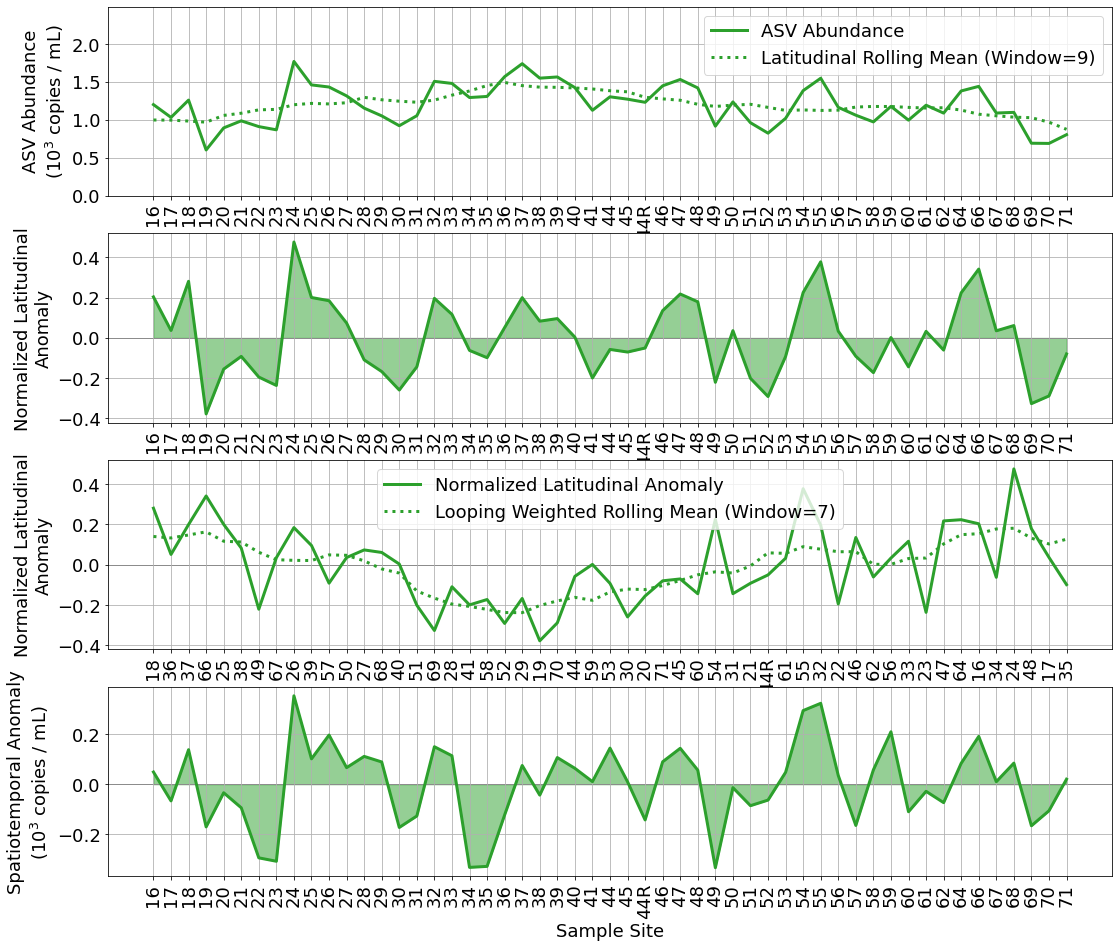

In [49]:
plot_STA_pipeline_example('2f52bfb075d038a1b72a4dd9d53a01e8') # example of ubiquitous ASV

/var/folders/yd/5vf5xvpn14q42xgt5trcdktc0000gn/T/ipykernel_86018/354577190.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set_ylabel('Spatiotemporal Anomaly',C='C1')


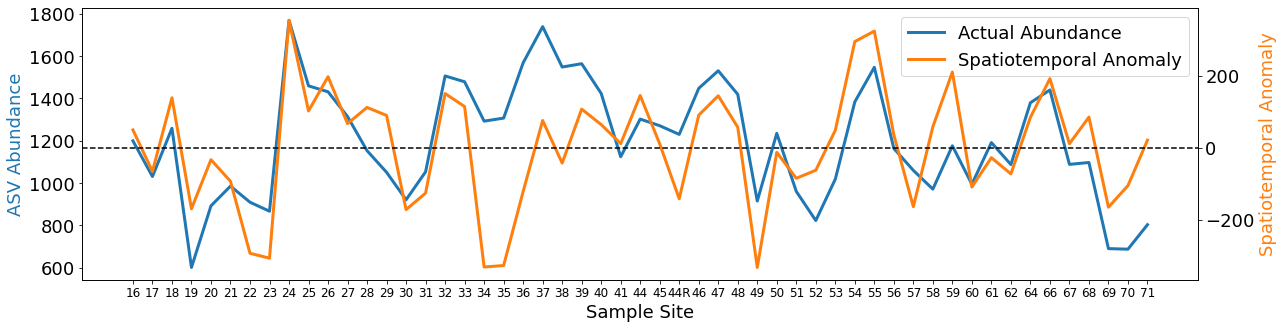

In [50]:
plot_original_and_anom('2f52bfb075d038a1b72a4dd9d53a01e8')

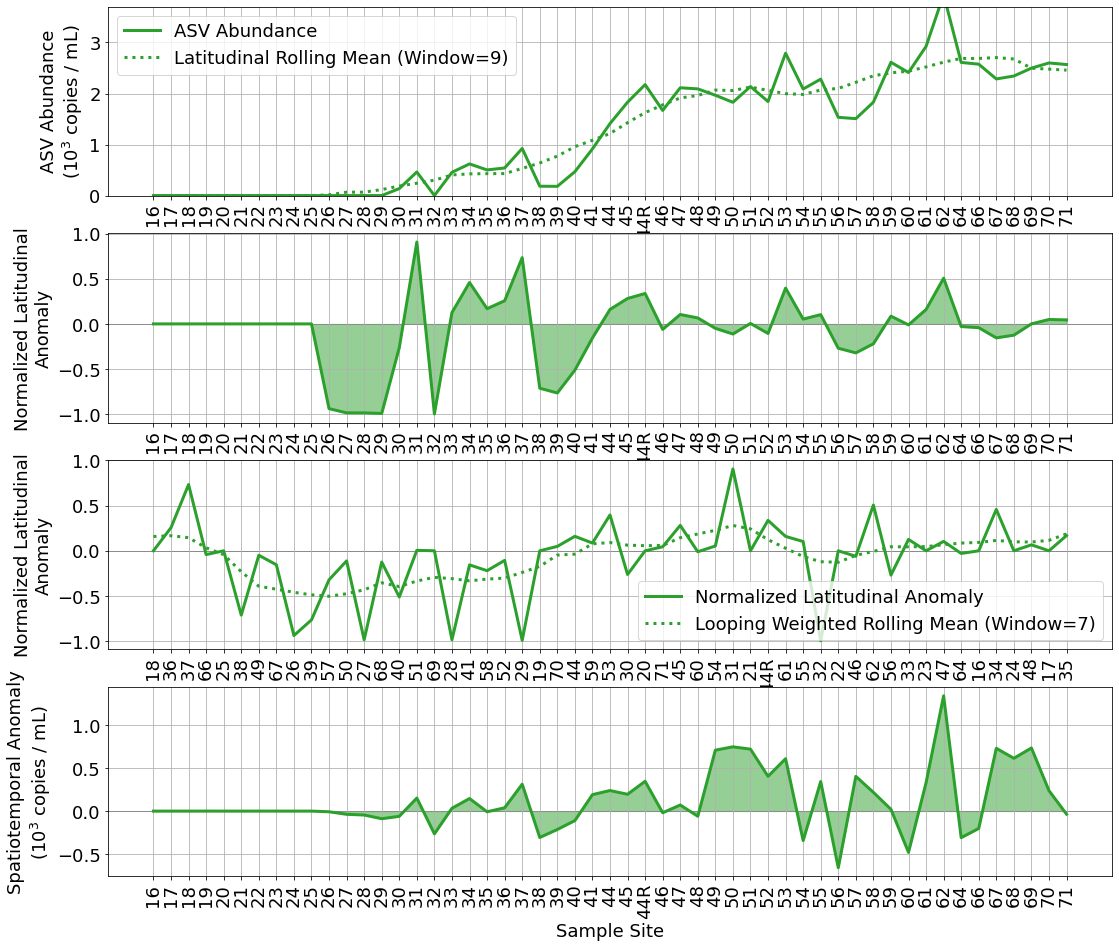

In [51]:
plot_STA_pipeline_example('93f178a72eea5198a7d679b5c07cfd6a') # example of zero abundance in north

/var/folders/yd/5vf5xvpn14q42xgt5trcdktc0000gn/T/ipykernel_86018/354577190.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set_ylabel('Spatiotemporal Anomaly',C='C1')


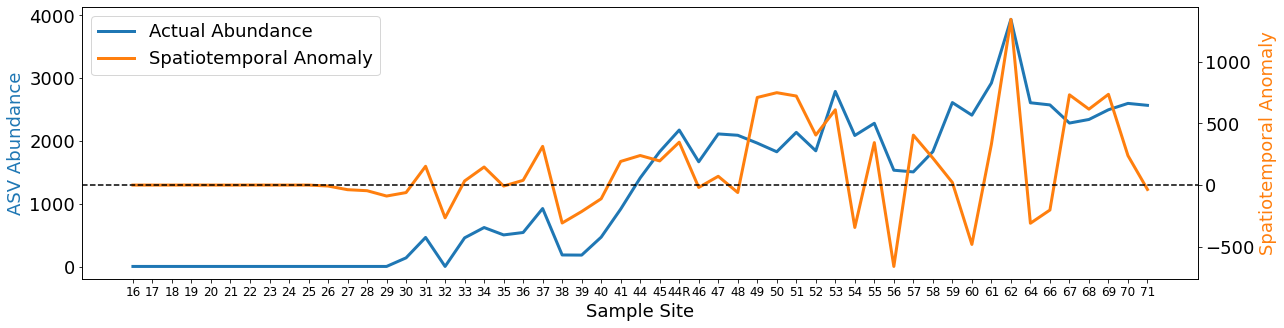

In [52]:
plot_original_and_anom('93f178a72eea5198a7d679b5c07cfd6a')

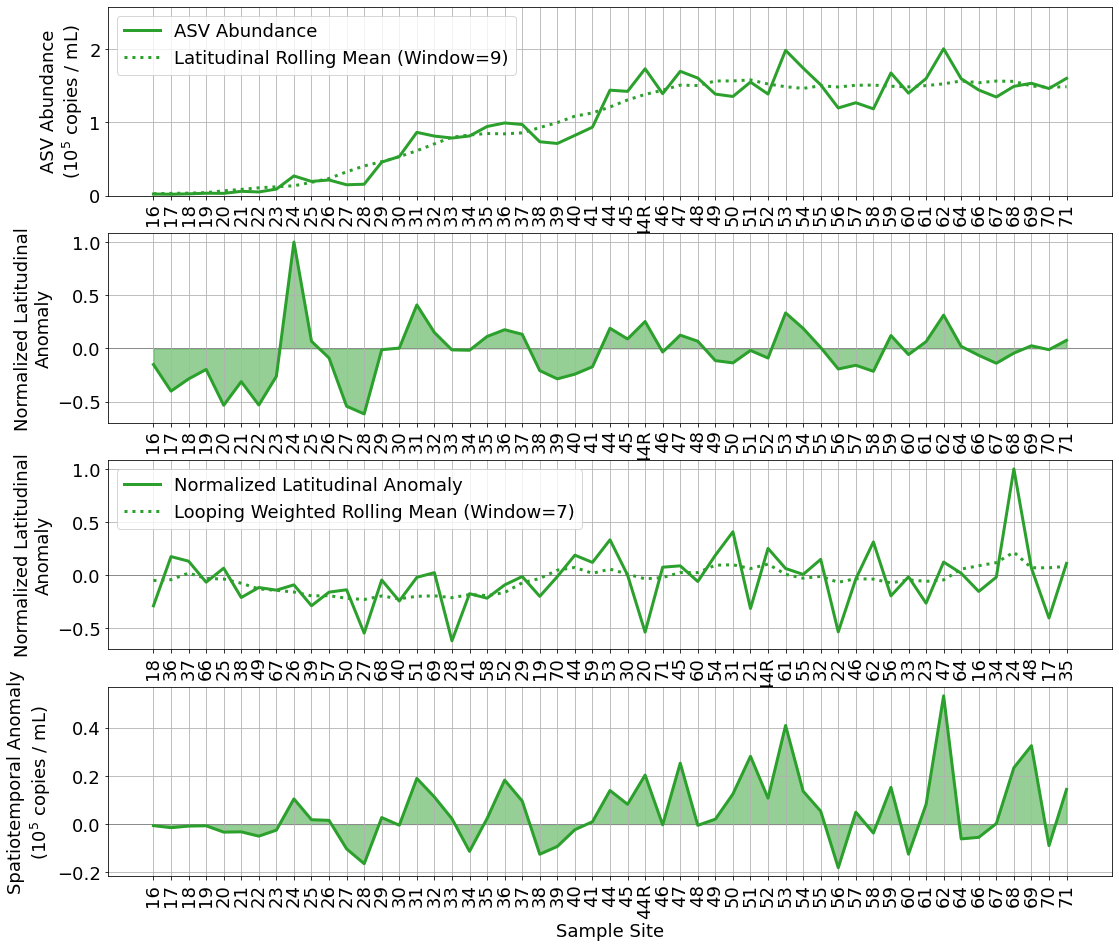

In [53]:
plot_STA_pipeline_example('e9f376c867c2a1506d5b0996f9839a20')

/var/folders/yd/5vf5xvpn14q42xgt5trcdktc0000gn/T/ipykernel_86018/354577190.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set_ylabel('Spatiotemporal Anomaly',C='C1')


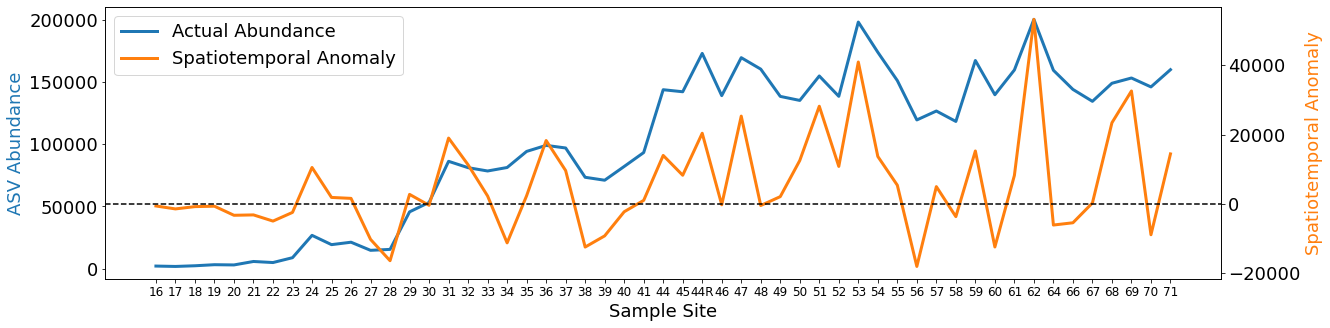

In [54]:
plot_original_and_anom('e9f376c867c2a1506d5b0996f9839a20')

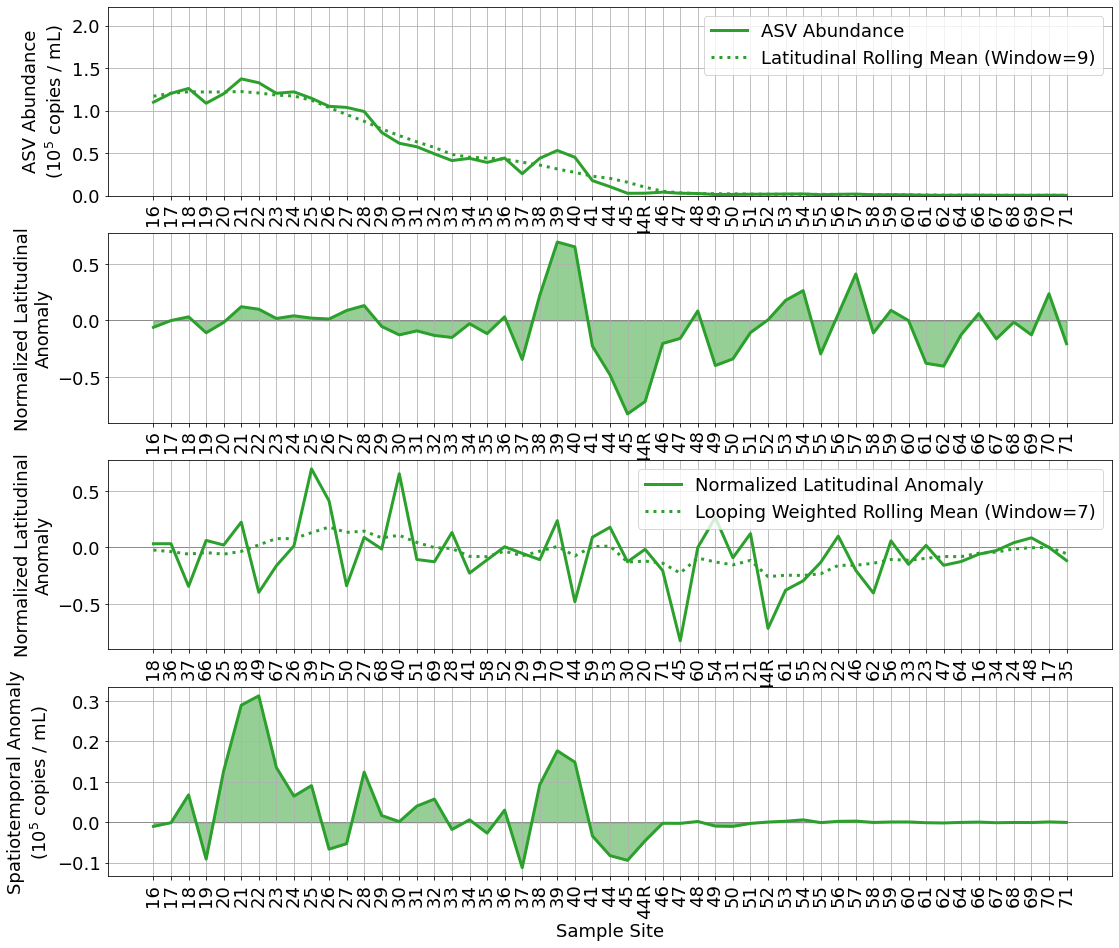

In [55]:
plot_STA_pipeline_example('86cd70d2450e3f44f4a7c543f53008ee') # example of low abundance in south

/var/folders/yd/5vf5xvpn14q42xgt5trcdktc0000gn/T/ipykernel_86018/354577190.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set_ylabel('Spatiotemporal Anomaly',C='C1')


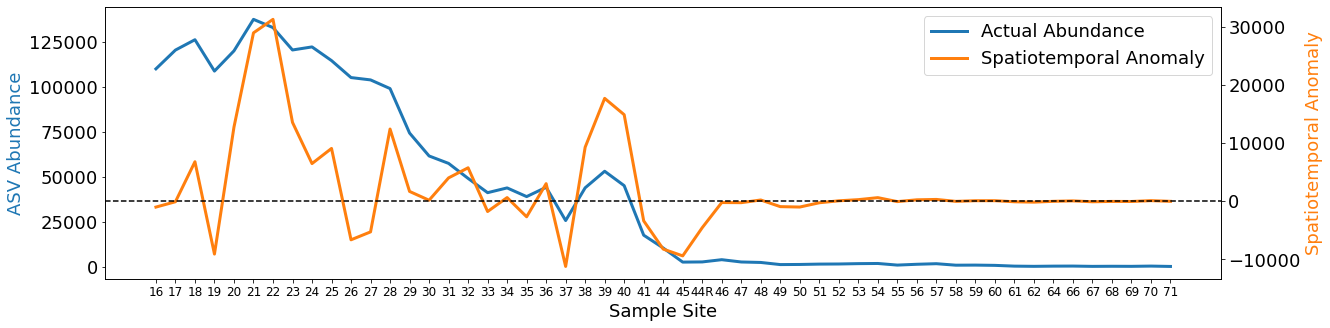

In [56]:
plot_original_and_anom('86cd70d2450e3f44f4a7c543f53008ee')

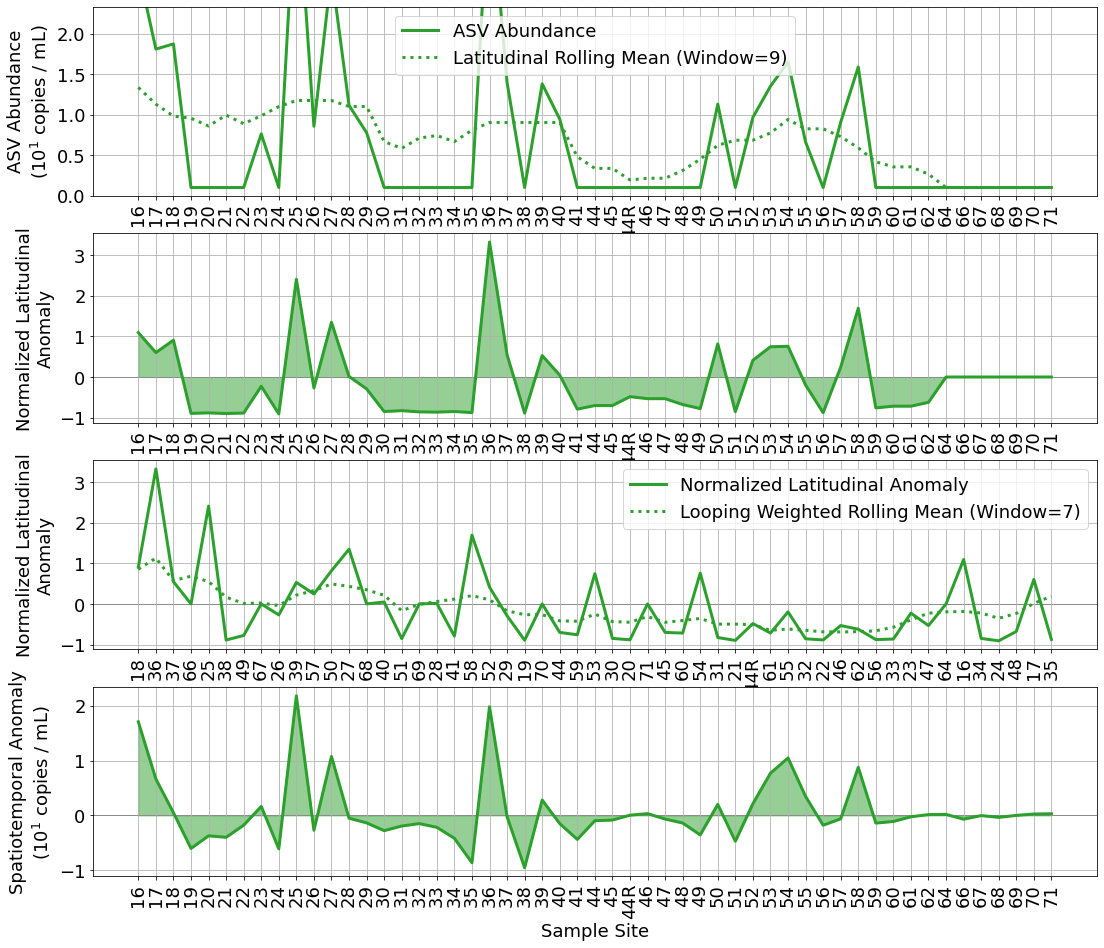

In [58]:
plot_STA_pipeline_example('d883e3b29658c861ac524bbfc2cef34d') # example of patchy abundance

/var/folders/yd/5vf5xvpn14q42xgt5trcdktc0000gn/T/ipykernel_86018/354577190.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set_ylabel('Spatiotemporal Anomaly',C='C1')


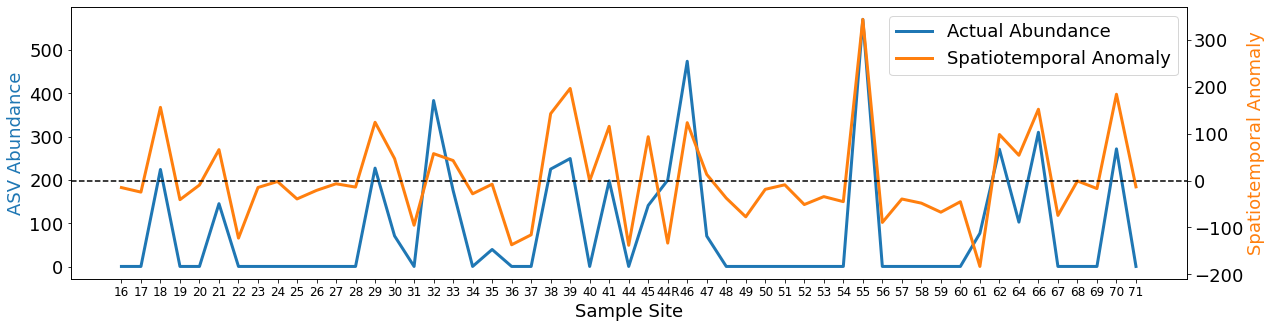

In [59]:
plot_original_and_anom('9996e9541ddacce18aa09ffe518a8eef')

## Sum Group Anomalies

Create eukaryotic phytoplankton only and cyano only DataFrames

In [60]:
euk_phyto_ASV_lat_temp_anom_sorted_df = phyto_ASV_lat_temp_anom_sorted_df[euk_ASVs]
cyan_ASV_lat_temp_anom_sorted_df = phyto_ASV_lat_temp_anom_sorted_df[cyan_ASVs]

Sum STA by group

In [61]:
euk_sum = pd.DataFrame()
for i in np.unique(euk_tax['Phytoplankton_Group']):
    sub_tax = euk_tax.iloc[np.where(euk_tax['Phytoplankton_Group'] == i)]['ASV_ID']
    filtered_sub_tax = [t for t in list(sub_tax) if t in list(euk_ASVs)]
    euk_sum[i] = np.sum(euk_phyto_ASV_lat_temp_anom_sorted_df.loc[:, euk_phyto_ASV_lat_temp_anom_sorted_df.columns.isin(filtered_sub_tax)],axis=1)

s = np.abs(euk_sum).sum()
euk_sum_sorted = euk_sum[s.sort_values(ascending=False).index[:]]
euk_sum_sorted.head()

,Prymnesiophyte,Dinoflagellate,Dictyochophyte,Chrysophyte,Unknown Eukaryote Chloroplast,Pelagophyte,Diatom,Chlorophyte,Prasinodermophyte,Cryptophyte
sample_id,,,,,,,,,,
16,-333.969629,89.987036,-49.977381,-179.647262,-168.192228,-76.805029,27.143210,-69.382566,-12.848812,10.185406
17,-96.809486,483.068234,-59.008683,-124.678090,-244.454688,-16.290086,20.008678,-20.601396,-7.666102,-0.882804
18,1001.268869,734.456012,680.255476,215.774260,68.056802,110.829831,68.528971,9.576012,-9.852365,-2.745265
19,-1167.595661,-863.236283,-597.277733,-12.009328,-1.901571,-105.905127,-44.062083,127.923658,12.454472,-2.172479
20,-350.564931,627.572379,-225.305894,-238.519809,4.178096,48.921635,-64.909874,41.297409,21.731504,-4.229902


In [62]:
cyan_sum = pd.DataFrame()
for i in np.unique(cyan_tax['Phytoplankton_Group']):
    sub_tax = cyan_tax.iloc[np.where(cyan_tax['Phytoplankton_Group'] == i)]['ASV_ID']
    cyan_sum[i] = (cyan_ASV_lat_temp_anom_sorted_df.loc[:, cyan_ASV_lat_temp_anom_sorted_df.columns.isin(sub_tax)]).sum(axis=1)
cyan_sum.head()

,Diazotroph,Picocyanobacteria
sample_id,,
16,-6.580226,-3967.232713
17,-16.200813,-6257.738603
18,-0.984962,5610.385205
19,-28.346925,-15423.968296
20,7.394596,6379.209983


In [63]:
phyto_df_final = pd.concat((euk_sum_sorted,cyan_sum),axis=1) # Group sum STA
phyto_df_final.head()

,Prymnesiophyte,Dinoflagellate,Dictyochophyte,Chrysophyte,Unknown Eukaryote Chloroplast,Pelagophyte,Diatom,Chlorophyte,Prasinodermophyte,Cryptophyte,Diazotroph,Picocyanobacteria
sample_id,,,,,,,,,,,,
16,-333.969629,89.987036,-49.977381,-179.647262,-168.192228,-76.805029,27.143210,-69.382566,-12.848812,10.185406,-6.580226,-3967.232713
17,-96.809486,483.068234,-59.008683,-124.678090,-244.454688,-16.290086,20.008678,-20.601396,-7.666102,-0.882804,-16.200813,-6257.738603
18,1001.268869,734.456012,680.255476,215.774260,68.056802,110.829831,68.528971,9.576012,-9.852365,-2.745265,-0.984962,5610.385205
19,-1167.595661,-863.236283,-597.277733,-12.009328,-1.901571,-105.905127,-44.062083,127.923658,12.454472,-2.172479,-28.346925,-15423.968296
20,-350.564931,627.572379,-225.305894,-238.519809,4.178096,48.921635,-64.909874,41.297409,21.731504,-4.229902,7.394596,6379.209983


### Stacked Abundance Plots 

Seperate by cyanobacteria & eukaryotes 

In [64]:
cyan_ASV_lat_temp_anom_sorted_df = phyto_ASV_lat_temp_anom_sorted_df[cyan_ASVs]
euk_ASV_lat_temp_anom_sorted_df = phyto_ASV_lat_temp_anom_sorted_df[euk_ASVs]

Save group-level and cyan/euk separated dataframes

In [65]:
#phyto_df_final.to_csv(highcov_dir + 'phyto_ASV_spatiotemporal_group_anoms_v3.csv')
#cyan_ASV_lat_temp_anom_sorted_df.to_csv(highcov_dir + 'cyan_phyto_ASV_spatiotemporal_anoms_v3.csv')
#euk_ASV_lat_temp_anom_sorted_df.to_csv(highcov_dir + 'euk_phyto_ASV_spatiotemporal_anoms_v3.csv')

Split up cyanobacteria by whether they're Pro, Syn, Diaz, or Unknown picocyano

In [66]:
pro_syn = pd.read_csv(isme_dir + 'pro_syn_assignments.csv',index_col=0)
pro_syn.head()

,Assignment,ProPortal_Assignment
ASV_ID,,
e9f376c867c2a1506d5b0996f9839a20,Prochlorococcus,Prochlorococcus_HLII
86cd70d2450e3f44f4a7c543f53008ee,Prochlorococcus,Prochlorococcus_HLI
d089e76cb77366eba904ed413876e849,Prochlorococcus,Prochlorococcus_HLII
27ca2b8f287c3a7e4d864cc870cf67b7,Prochlorococcus,Prochlorococcus_unassigned
7a1011dfbc8b253cb0032a00e74454e9,Prochlorococcus,Prochlorococcus_HLI


In [67]:
def count_keys_with_same_value(my_dict):
    value_counts = defaultdict(int)
    for key, value in my_dict.items():
        value_counts[value] += 1
    return value_counts

In [68]:
cyan_ASV_dict = {}
for ASV in cyan_ASVs:
    if ASV in pro_syn.index:
        if pro_syn.loc[ASV]['Assignment'] == 'Prochlorococcus':
            cyan_ASV_dict[ASV] = 'Prochlorococcus'
        elif pro_syn.loc[ASV]['Assignment'] == 'Synechococcus':
            cyan_ASV_dict[ASV] = 'Synechococcus'
    else:
        pp_group = pp_tax[pp_tax['ASV_ID'] == ASV]['Phytoplankton_Group'].values[0]
        if pp_group == 'Diazotroph':
            cyan_ASV_dict[ASV] = 'Diazotroph'
        else:
            cyan_ASV_dict[ASV] = 'Unknown Picocyanobacteria'
        
cyan_counts = count_keys_with_same_value(cyan_ASV_dict)
cyan_counts

defaultdict(int,
            {'Prochlorococcus': 62,
             'Synechococcus': 7,
             'Unknown Picocyanobacteria': 3,
             'Diazotroph': 2})

Set up color palette for each phytoplankton group

In [69]:
def plot_color_column(ax, colors):    
    reformat_colors = np.array([to_rgb(i) for i in colors])
    reformat_colors = reformat_colors.reshape(len(reformat_colors), 1, 3)

    # Display the color column
    ax.imshow(reformat_colors, aspect='auto')

    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax

In [70]:
cyan_color_dict= {'Prochlorococcus':['#2c6d47','#3B945E','#5bbe84'],
              'Synechococcus':['#4B9CD3'],
              'Diazotroph':['#f17941'],
              'Unknown Picocyanobacteria':['#808080']}

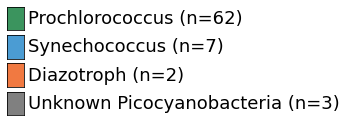

In [71]:
fig, ax = plt.subplots(4,1,figsize=(0.3, 2))
plt.subplots_adjust(wspace=2)

cyan_color_dict_temp= {'Prochlorococcus':['#3B945E'],
              'Synechococcus':['#4B9CD3'],
              'Diazotroph':['#f17941'],
              'Unknown Picocyanobacteria':['#808080']}

count = 0
for key, value in cyan_color_dict_temp.items():
    plot_color_column(ax[count],value)
    ax[count].yaxis.set_label_position("right")
    ax[count].yaxis.tick_right()
    ax[count].set_ylabel('%s (n=%s)'%(key,cyan_counts[key]),rotation=360,
                         horizontalalignment='left',verticalalignment='center')
    count += 1
    
#plt.savefig(euk_paper_dir + 'figs/cyan_color_code.pdf',dpi=350, bbox_inches='tight', format='pdf')

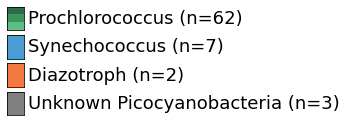

In [72]:
fig, ax = plt.subplots(4,1,figsize=(0.3, 2))
plt.subplots_adjust(wspace=2)

count = 0
for key, value in cyan_color_dict.items():
    plot_color_column(ax[count],value)
    ax[count].yaxis.set_label_position("right")
    ax[count].yaxis.tick_right()
    ax[count].set_ylabel('%s (n=%s)'%(key,cyan_counts[key]),rotation=360,
                         horizontalalignment='left',verticalalignment='center')
    count += 1
    
#plt.savefig(euk_paper_dir + 'figs/cyan_color_code.pdf',dpi=350, bbox_inches='tight', format='pdf')

In [73]:
# get sum of copy counts
s = np.abs(cyan_ASV_no_low_freq_df).sum()
cyan_ASV_no_low_freq_df_sorted = cyan_ASV_no_low_freq_df[s.sort_values(ascending=False).index[:]]

pico_colors = []
pro_count = 0
for ASV in cyan_ASV_no_low_freq_df_sorted:
    if cyan_ASV_dict[ASV] == 'Prochlorococcus': # cycle through greens
        pico_colors.append(cyan_color_dict[cyan_ASV_dict[ASV]][pro_count])
        if pro_count == 2:
            pro_count = 0
        else:
            pro_count += 1
    else:
        pico_colors.append(cyan_color_dict[cyan_ASV_dict[ASV]][0])

Text(0.5, 0, 'Sample Site')

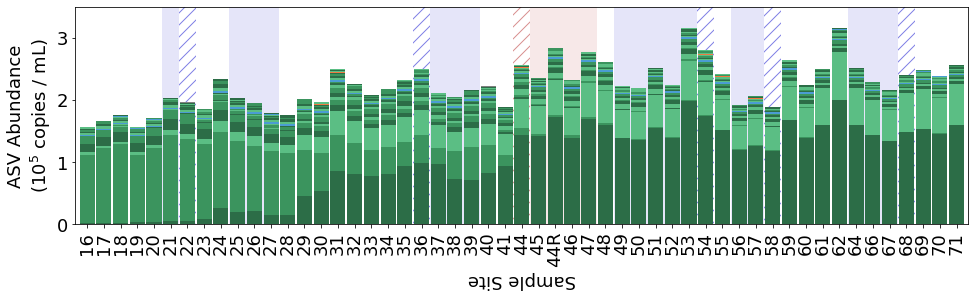

In [74]:
#fig,ax = plt.subplots(1,1,figsize=(20,7))
fig,ax = plt.subplots(1,1,figsize=(16,4))

# Plot with highest abundace on the bottom
cyan_ASV_no_low_freq_df_sorted.plot(kind='bar',stacked=True,ax=ax,width=0.9,color=pico_colors)
ax.get_legend().remove() # otherwise will try to plot every ASV label

pwr = 5
ax.ticklabel_format(axis='y', style='sci', scilimits=(pwr,pwr)) # Add sci notation
ax.yaxis.get_offset_text().set_visible(False) # Remove sci notation label
ax.set_ylabel('ASV Abundance\n($10^5$ copies / mL)')

ymax=3.5*(10**5)
ax.set_ylim([0,ymax])

################# EDDY SHADING #################

eddy_type_dict = {'in_anti':['firebrick','x'],
                  'near_anti':['firebrick','//'],
                  'in_cyc':['mediumblue','x'],
                  'near_cyc':['mediumblue','//']}

for eddy_type,values in eddy_type_dict.items():
    eddy_ids = np.unique(metadata_df.iloc[np.where(metadata_df[eddy_type] != 0)[0]][eddy_type])
    for ID in eddy_ids:
        inds = np.where([metadata_df[eddy_type] == ID])[1]
        
        if (eddy_type == 'in_anti') or (eddy_type == 'in_cyc'):
            ax.fill_between([inds[0]-0.5,inds[-1]+0.5],0,y2=ymax, 
                            facecolor=values[0],alpha=0.1,linewidth=0)
        else:
            for i in np.arange(0,len(inds)):
                ax.fill_between([inds[i]-0.5,inds[i]+0.5],0,y2=ymax,hatch=values[1], 
                            facecolor='none', edgecolor=values[0],alpha=0.5,linewidth=0)

eddy_ypos = 3.2*(10**5)
#ax.text(3.25,eddy_ypos,'Shrutie')
#ax.text(8.5,eddy_ypos,'Zinka')
#ax.text(20.75,eddy_ypos,'Dean')
#ax.text(27.5,eddy_ypos,'Josh')
#ax.text(32.25,eddy_ypos,'Sharon')
#ax.text(38.,eddy_ypos,'Cathy')
#ax.text(45.75,eddy_ypos,'Koko')
    
###################################################
# Add a latitude axis
#ax0b = ax.twiny()
#ax0b.set_xlim(ax.get_xlim())
#ax0b.set_xticks(np.arange(0,53,5))
#ax0b.set_xticklabels([str(round(i,1)) for i in metadata_df.latitude][::5])
#ax0b.set_xlabel('Latitude')
ax.set_xlabel('Sample Site',rotation=180)

#plt.savefig(euk_paper_dir + 'figs/cyan_stacked_ASV.pdf',dpi=350, bbox_inches='tight', format='pdf')
#plt.show()

Text(0.5, 0, 'Sample Site')

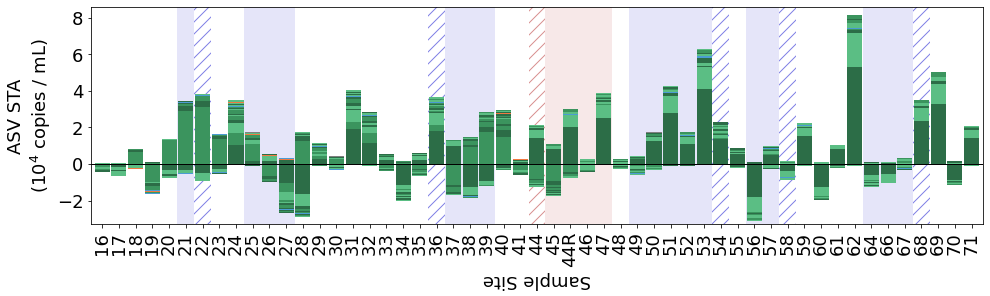

In [75]:
#fig,ax = plt.subplots(1,1,figsize=(20,7))
fig,ax = plt.subplots(1,1,figsize=(16,4))

# Plot with highest abundace on the bottom
cyan_ASV_lat_temp_anom_sorted_df.plot(kind='bar',stacked=True,ax=ax,width=0.9,color=pico_colors)
ax.get_legend().remove()

# Add sci notation
pwr = 4
ax.ticklabel_format(axis='y', style='sci', scilimits=(pwr,pwr))

# Remove sci notation label
ax.yaxis.get_offset_text().set_visible(False)
ax.set_ylabel('ASV STA\n($10^4$ copies / mL)')

ax.axhline(0,c='k',linewidth=1)

ymin=-3.3*(10**4)
ymax=8.6*(10**4)
ax.set_ylim([ymin,ymax])

################# EDDY SHADING #################

eddy_type_dict = {'in_anti':['firebrick','x'],
                  'near_anti':['firebrick','//'],
                  'in_cyc':['mediumblue','x'],
                  'near_cyc':['mediumblue','//']}

for eddy_type,values in eddy_type_dict.items():
    eddy_ids = np.unique(metadata_df.iloc[np.where(metadata_df[eddy_type] != 0)[0]][eddy_type])
    for ID in eddy_ids:
        inds = np.where([metadata_df[eddy_type] == ID])[1]
        
        if (eddy_type == 'in_anti') or (eddy_type == 'in_cyc'):
            ax.fill_between([inds[0]-0.5,inds[-1]+0.5],ymin,y2=ymax, 
                            facecolor=values[0],alpha=0.1,linewidth=0)
        else:
            for i in np.arange(0,len(inds)):
                ax.fill_between([inds[i]-0.5,inds[i]+0.5],ymin,y2=ymax,hatch=values[1], 
                            facecolor='none', edgecolor=values[0],alpha=0.5,linewidth=0)

eddy_ypos = 7.8*(10**4)
#ax.text(3.5,eddy_ypos,'Shrutie')
#ax.text(8.75,eddy_ypos,'Zinka')
#ax.text(20.75,eddy_ypos,'Dean')
#ax.text(27.5,eddy_ypos,'Josh')
#ax.text(32.5,eddy_ypos,'Sharon')
#ax.text(38.25,eddy_ypos,'Cathy')
#ax.text(46,eddy_ypos,'Koko')

###################################################

# Add a latitude axis
#ax0b = ax.twiny()
#ax0b.set_xlim(ax.get_xlim())
#ax0b.set_xticks(np.arange(0,53,5))
#ax0b.set_xticklabels([str(round(i,1)) for i in metadata_df.latitude][::5])
#ax0b.set_xlabel('Latitude')
ax.set_xlabel('Sample Site',rotation=180)

#plt.savefig(euk_paper_dir + 'figs/cyan_stacked_ASV_STA.pdf',dpi=350, bbox_inches='tight', format='pdf')
#plt.show()

Sum by cyano type

In [76]:
cyan_group_raw_df = pd.DataFrame()
for i in ['Prochlorococcus','Synechococcus','Diazotroph','Unknown Picocyanobacteria']:
    filtered_sub_tax = []
    for key, value in cyan_ASV_dict.items():
        if value == i:
            filtered_sub_tax.append(key)
    cyan_group_raw_df[i] = np.sum(cyan_ASV_no_low_freq_df_sorted.loc[:, cyan_ASV_no_low_freq_df_sorted.columns.isin(filtered_sub_tax)],axis=1)

s = np.abs(cyan_group_raw_df).sum()
cyan_group_raw_df_sorted = cyan_group_raw_df[s.sort_values(ascending=False).index[:]]
cyan_group_raw_df_sorted.head()

,Prochlorococcus,Synechococcus,Diazotroph,Unknown Picocyanobacteria
16,154179.561700,1943.180454,15.966064,142.995229
17,164524.926680,2404.701142,17.011887,89.090769
18,173805.948572,2557.089105,31.017010,71.221151
19,153534.224871,2699.944954,0.000000,97.210581
20,168876.031739,2571.646489,78.427659,49.558849


In [77]:
cyan_group_df = pd.DataFrame()
for i in ['Prochlorococcus','Synechococcus','Diazotroph','Unknown Picocyanobacteria']:
    filtered_sub_tax = []
    for key, value in cyan_ASV_dict.items():
        if value == i:
            filtered_sub_tax.append(key)
    cyan_group_df[i] = np.sum(cyan_ASV_lat_temp_anom_sorted_df.loc[:, cyan_ASV_lat_temp_anom_sorted_df.columns.isin(filtered_sub_tax)],axis=1)
cyan_group_df

s = np.abs(cyan_group_df).sum()
cyan_group_df_sorted = cyan_group_df[s.sort_values(ascending=False).index[:]]
cyan_group_df_sorted.head()

,Prochlorococcus,Synechococcus,Diazotroph,Unknown Picocyanobacteria
sample_id,,,,
16,-3613.876338,-406.340169,-6.580226,52.983794
17,-6157.690027,-132.794086,-16.200813,32.745509
18,5671.736151,-79.394475,-0.984962,18.043530
19,-15612.200747,182.391299,-28.346925,5.841152
20,6269.764940,107.015593,7.394596,2.429450


In [78]:
#cyan_group_df_sorted.to_csv(highcov_dir + 'cyano_ASV_spatiotemporal_group_anoms_v3.csv')

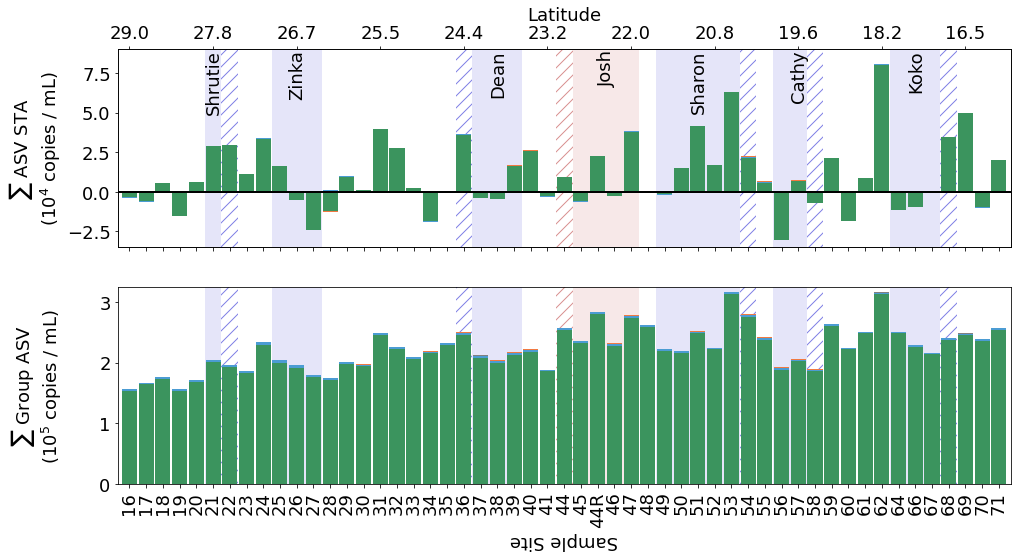

In [80]:
fig,ax = plt.subplots(2,1,figsize=(16,8))

################# STA PLOT #################

cyan_center_colors = [cyan_color_dict['Prochlorococcus'][1],
                      cyan_color_dict['Synechococcus'][0],
                      cyan_color_dict['Diazotroph'][0],
                      cyan_color_dict['Unknown Picocyanobacteria'][0]]
cyan_group_df_sorted.plot(kind='bar',stacked=True,ax=ax[0],width=0.9,color=cyan_center_colors)
ax[0].get_legend().remove()
ax[0].axhline(0,c='k',linewidth=2)
ax[0].set_xlabel('')

pwr = 4
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(pwr,pwr)) # Add sci notation
ax[0].yaxis.get_offset_text().set_visible(False) # Remove sci notation label
ax[0].set_ylabel('$\sum$ ASV STA\n($10^%s$ copies / mL)'%(pwr),fontsize=fontsize)


ax1 = ax[0].twiny()
ax1.set_xlim(ax[0].get_xlim())
ax1.set_xticks(np.arange(0,53,5))
ax1.set_xticklabels([str(round(i,1)) for i in metadata_df.latitude][::5])
ax1.set_xlabel('Latitude')

ymin0,ymax0 = -3.5*(10**4),9*(10**4)
ax[0].set_ylim([ymin0,ymax0])

# Eddy labels
eddy_ypos = ymax0
ax[0].text(4.5,eddy_ypos,'Shrutie',rotation=90,verticalalignment='top')
ax[0].text(9.5,eddy_ypos,'Zinka',rotation=90,verticalalignment='top')
ax[0].text(21.5,eddy_ypos,'Dean',rotation=90,verticalalignment='top')
ax[0].text(28,eddy_ypos,'Josh',rotation=90,verticalalignment='top')
ax[0].text(33.5,eddy_ypos,'Sharon',rotation=90,verticalalignment='top')
ax[0].text(39.5,eddy_ypos,'Cathy',rotation=90,verticalalignment='top')
ax[0].text(46.5,eddy_ypos,'Koko',rotation=90,verticalalignment='top')

ax[0].set_xticklabels([])

################# ABUNDANCE PLOT #################

cyan_group_raw_df_sorted.plot(kind='bar',stacked=True,ax=ax[1],width=0.9,color=cyan_center_colors)
ax[1].get_legend().remove()

pwr = 5
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(pwr,pwr)) # Add sci notation
ax[1].yaxis.get_offset_text().set_visible(False) # Remove sci notation label
ax[1].set_ylabel('$\sum$ Group ASV\n($10^%s$ copies / mL)'%(pwr),fontsize=fontsize,labelpad=35)

ymin1,ymax1 = 0,3.25*(10**5)
ax[1].set_ylim([ymin1,ymax1])
ax[1].set_xlabel('Sample Site',rotation=180)


################# EDDY SHADING #################

eddy_type_dict = {'in_anti':['firebrick','x'],
                  'near_anti':['firebrick','//'],
                  'in_cyc':['mediumblue','x'],
                  'near_cyc':['mediumblue','//']}


for eddy_type,values in eddy_type_dict.items():
    eddy_ids = np.unique(metadata_df.iloc[np.where(metadata_df[eddy_type] != 0)[0]][eddy_type])
    for ID in eddy_ids:
        inds = np.where([metadata_df[eddy_type] == ID])[1]
        
        for a in ax:
            if a == ax[0]:
                ymin,ymax=ymin0,ymax0
            elif a == ax[1]:
                ymin,ymax=ymin1,ymax1
                
            if (eddy_type == 'in_anti') or (eddy_type == 'in_cyc'):
                a.fill_between([inds[0]-0.5,inds[-1]+0.5],ymin,y2=ymax, 
                                facecolor=values[0],alpha=0.1,linewidth=0)
            else:
                for i in np.arange(0,len(inds)):
                    a.fill_between([inds[i]-0.5,inds[i]+0.5],ymin,y2=ymax,hatch=values[1], 
                                facecolor='none', edgecolor=values[0],alpha=0.5,linewidth=0)


#plt.savefig(euk_paper_dir + 'figs/supp/prelim/cyan_group_STA_v3.pdf',dpi=350, bbox_inches='tight', format='pdf')
plt.show()

### Repeat for eukaryotic phytoplankton

In [81]:
euk_ASV_dict = {}
for ASV in euk_ASVs:
    euk_ASV_dict[ASV] = pp_tax[pp_tax['ASV_ID'] == ASV]['Phytoplankton_Group'].values[0]

euk_counts = count_keys_with_same_value(euk_ASV_dict)
euk_counts

defaultdict(int,
            {'Dictyochophyte': 29,
             'Prymnesiophyte': 151,
             'Pelagophyte': 28,
             'Chrysophyte': 42,
             'Unknown Eukaryote Chloroplast': 20,
             'Diatom': 16,
             'Chlorophyte': 10,
             'Prasinodermophyte': 4,
             'Cryptophyte': 1,
             'Dinoflagellate': 31})

In [82]:
euk_color_dict = {'Prymnesiophyte':['#4056A1'],
             'Dinoflagellate':['#9269b5'],
             'Dictyochophyte':['#ad2713'],
             'Chrysophyte':['#376E6F'],
             'Unknown Eukaryote Chloroplast':['#808080'],
             'Pelagophyte':['#D79922'],
             'Diatom':['#E98074'],
             'Chlorophyte':['#88BDBC'],
             'Prasinodermophyte':['#899c75'],
             'Cryptophyte':['#e6ccb3']}

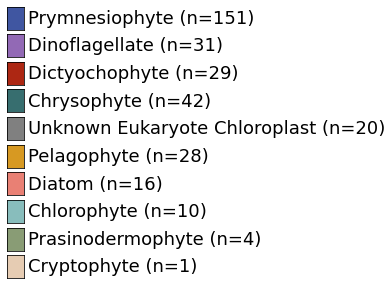

In [83]:
fig, ax = plt.subplots(10,1,figsize=(0.3,5))
plt.subplots_adjust(wspace=2)

count = 0
for key, value in euk_color_dict.items():
    plot_color_column(ax[count],value)
    ax[count].yaxis.set_label_position("right")
    ax[count].yaxis.tick_right()
    ax[count].set_ylabel('%s (n=%s)'%(key,euk_counts[key]),rotation=360,
                         horizontalalignment='left',verticalalignment='center')
    count += 1
    
#plt.savefig(euk_paper_dir + 'figs/euk_color_code.pdf',dpi=350, bbox_inches='tight', format='pdf')

In [84]:
# get sum of copy counts
s = np.abs(euk_ASV_no_low_freq_df).sum()
euk_ASV_no_low_freq_df_sorted = euk_ASV_no_low_freq_df[s.sort_values(ascending=False).index[:]]

euk_colors = []
for ASV in euk_ASV_no_low_freq_df_sorted:
    euk_colors.append(euk_color_dict[euk_ASV_dict[ASV]][0])

### Gene copy pie chart

In [85]:
group_raw_df = pd.DataFrame()
for i in np.unique(pp_tax['Phytoplankton_Group']):
    sub_tax = pp_tax.iloc[np.where(pp_tax['Phytoplankton_Group'] == i)]['ASV_ID']
    group_raw_df[i] = np.sum(phyto_ASV_no_low_freq_df.loc[:, phyto_ASV_no_low_freq_df.columns.isin(sub_tax)],axis=1)

group_raw_df.head()

,Chlorophyte,Chrysophyte,Cryptophyte,Diatom,Diazotroph,Dictyochophyte,Dinoflagellate,Pelagophyte,Picocyanobacteria,Prasinodermophyte,Prymnesiophyte,Unknown Eukaryote Chloroplast
16,120.048054,1282.167125,17.999746,291.804371,17.966064,3573.225935,3236.385190,602.908487,156337.737383,7.659004,6016.537110,874.617607
17,151.221169,1520.917838,1.000000,305.653305,19.011887,3808.370939,3859.104849,670.488469,167090.718590,12.158246,6621.224888,804.684933
18,175.653141,1840.307663,1.000000,361.657441,33.017010,4493.900185,4350.723707,771.954263,176506.258828,8.325177,7667.011736,1084.202615
19,349.989462,1357.965788,1.000000,219.377400,2.000000,2192.227938,2209.996038,493.571158,156403.380406,36.351655,4352.516817,830.499092
20,222.412926,1327.449856,1.000000,210.655637,80.427659,2953.505816,4225.065450,651.309179,171569.237077,50.232985,5939.625662,999.633590


In [86]:
all_euk_grp_copies = group_raw_df[[i for i in group_raw_df if ((i != 'Diazotroph') & (i != 'Picocyanobacteria'))]]
sum_all_euk_grp_copies = all_euk_grp_copies.sum(axis=1)
all_pro_grp_copies = group_raw_df[['Diazotroph','Picocyanobacteria']]
sum_all_pro_grp_copies = all_pro_grp_copies.sum(axis=1)

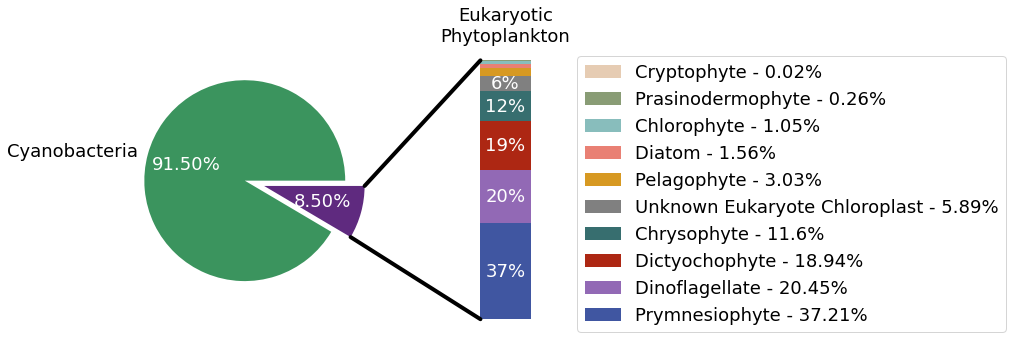

In [87]:
# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

############## PIE CHARTS ##############
y = np.array([np.sum(sum_all_pro_grp_copies),np.sum(sum_all_euk_grp_copies)])


# rotate so that first wedge is split by the x-axis
angle = -180 * y[0]
wedges, _, autotexts = ax1.pie(y,autopct='%1.2f%%',labels=['Cyanobacteria',''],explode=[0.1, 0.1],colors=[cyan_color_dict['Prochlorococcus'][1],'#5F2A7F']) 
for autotext in autotexts:
    autotext.set_color('white')

############## EUK BAR CHART ##############

# bar chart parameters
euk_ratios = np.divide(all_euk_grp_copies.sum(axis=0),np.sum(all_euk_grp_copies.sum(axis=0)))
euk_labels = all_euk_grp_copies.columns

formatted_labels = []
euk_color_code = []
for l in np.arange(0,len(euk_labels)):
    formatted_labels.append('%s - %s%%'%(euk_labels[l], round(euk_ratios[l]*100,2)))
    euk_color_code.append(euk_color_dict[euk_labels[l]])
    
# Sort the bar chart
euk_labels_sorted, euk_ratios_sorted,euk_color_code_sorted =  zip(*sorted(zip(formatted_labels, euk_ratios,euk_color_code),key=lambda x: x[1],reverse=True))

# Adding from the top matches the legend.
bottom, width = 1, 0.2
for j, (height, label) in enumerate(reversed([*zip(euk_ratios_sorted, euk_labels_sorted)])):
    bottom -= height
    
    bc = ax2.bar(0, height, width, bottom=bottom, label=label, color=euk_color_code_sorted[::-1][j])
    
    if j > 4:
        ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center', color='w')

ax2.set_title('Eukaryotic\nPhytoplankton')
ax2.legend(bbox_to_anchor=(0.75,1))
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# LINES 
# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[1].theta1, wedges[1].theta2
center, r = wedges[1].center, wedges[1].r
bar_height = sum(euk_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color('k')
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color('k')
con.set_linewidth(4)
ax2.add_artist(con)

plt.show()

### Abundance Stats

In [88]:
# get sum of copy counts
s = all_euk_grp_copies.mean()
all_euk_grp_copies_sorted = all_euk_grp_copies[s.sort_values(ascending=False).index[:]]
all_euk_grp_copies_sorted.head()

,Prymnesiophyte,Dinoflagellate,Dictyochophyte,Chrysophyte,Unknown Eukaryote Chloroplast,Pelagophyte,Diatom,Chlorophyte,Prasinodermophyte,Cryptophyte
16,6016.537110,3236.385190,3573.225935,1282.167125,874.617607,602.908487,291.804371,120.048054,7.659004,17.999746
17,6621.224888,3859.104849,3808.370939,1520.917838,804.684933,670.488469,305.653305,151.221169,12.158246,1.000000
18,7667.011736,4350.723707,4493.900185,1840.307663,1084.202615,771.954263,361.657441,175.653141,8.325177,1.000000
19,4352.516817,2209.996038,2192.227938,1357.965788,830.499092,493.571158,219.377400,349.989462,36.351655,1.000000
20,5939.625662,4225.065450,2953.505816,1327.449856,999.633590,651.309179,210.655637,222.412926,50.232985,1.000000


In [89]:
euk_sum_by_sample = all_euk_grp_copies_sorted.sum(axis=1)

In [90]:
euk_abund_table = [['Group','Mean (copies/mL)','Std. Dev.','CV (%)'],
                   ['All',round(np.mean(euk_sum_by_sample),1),round(np.std(euk_sum_by_sample),1),round((np.std(euk_sum_by_sample)/np.mean(euk_sum_by_sample))*100,1)]]
euk_abund_table

[['Group', 'Mean (copies/mL)', 'Std. Dev.', 'CV (%)'],
 ['All', 20785.1, 3569.5, 17.2]]

In [91]:
gp_mean = all_euk_grp_copies_sorted.mean(axis=0)
gp_std = all_euk_grp_copies_sorted.std(axis=0)

for gp in all_euk_grp_copies_sorted.columns:
    euk_abund_table.append([gp,round(gp_mean[gp],1),round(gp_std[gp],1),round((gp_std[gp]/gp_mean[gp])*100,1)])

In [95]:
#import csv
#save_dir = '../G4_traj_phyto_paper/'
#with open(save_dir + 'euk_gp_table.csv', 'w', newline='') as f:
#    writer = csv.writer(f)
#    writer.writerows(euk_abund_table)
#f.close()

### STA Stacked Plots

In [92]:
euk_sum_sorted.head()

,Prymnesiophyte,Dinoflagellate,Dictyochophyte,Chrysophyte,Unknown Eukaryote Chloroplast,Pelagophyte,Diatom,Chlorophyte,Prasinodermophyte,Cryptophyte
sample_id,,,,,,,,,,
16,-333.969629,89.987036,-49.977381,-179.647262,-168.192228,-76.805029,27.143210,-69.382566,-12.848812,10.185406
17,-96.809486,483.068234,-59.008683,-124.678090,-244.454688,-16.290086,20.008678,-20.601396,-7.666102,-0.882804
18,1001.268869,734.456012,680.255476,215.774260,68.056802,110.829831,68.528971,9.576012,-9.852365,-2.745265
19,-1167.595661,-863.236283,-597.277733,-12.009328,-1.901571,-105.905127,-44.062083,127.923658,12.454472,-2.172479
20,-350.564931,627.572379,-225.305894,-238.519809,4.178096,48.921635,-64.909874,41.297409,21.731504,-4.229902


In [93]:
euk_group_colors = []
for group in euk_sum_sorted.columns:
    euk_group_colors.append(euk_color_dict[group][0])
euk_group_colors

['#4056A1',
 '#9269b5',
 '#ad2713',
 '#376E6F',
 '#808080',
 '#D79922',
 '#E98074',
 '#88BDBC',
 '#899c75',
 '#e6ccb3']

In [94]:
euk_raw_df = group_raw_df.drop(columns=['Picocyanobacteria','Diazotroph'])

s = np.abs(euk_raw_df).sum()
euk_raw_df_sorted = euk_raw_df[s.sort_values(ascending=False).index[:]]
euk_raw_df_sorted.head()

,Prymnesiophyte,Dinoflagellate,Dictyochophyte,Chrysophyte,Unknown Eukaryote Chloroplast,Pelagophyte,Diatom,Chlorophyte,Prasinodermophyte,Cryptophyte
16,6016.537110,3236.385190,3573.225935,1282.167125,874.617607,602.908487,291.804371,120.048054,7.659004,17.999746
17,6621.224888,3859.104849,3808.370939,1520.917838,804.684933,670.488469,305.653305,151.221169,12.158246,1.000000
18,7667.011736,4350.723707,4493.900185,1840.307663,1084.202615,771.954263,361.657441,175.653141,8.325177,1.000000
19,4352.516817,2209.996038,2192.227938,1357.965788,830.499092,493.571158,219.377400,349.989462,36.351655,1.000000
20,5939.625662,4225.065450,2953.505816,1327.449856,999.633590,651.309179,210.655637,222.412926,50.232985,1.000000


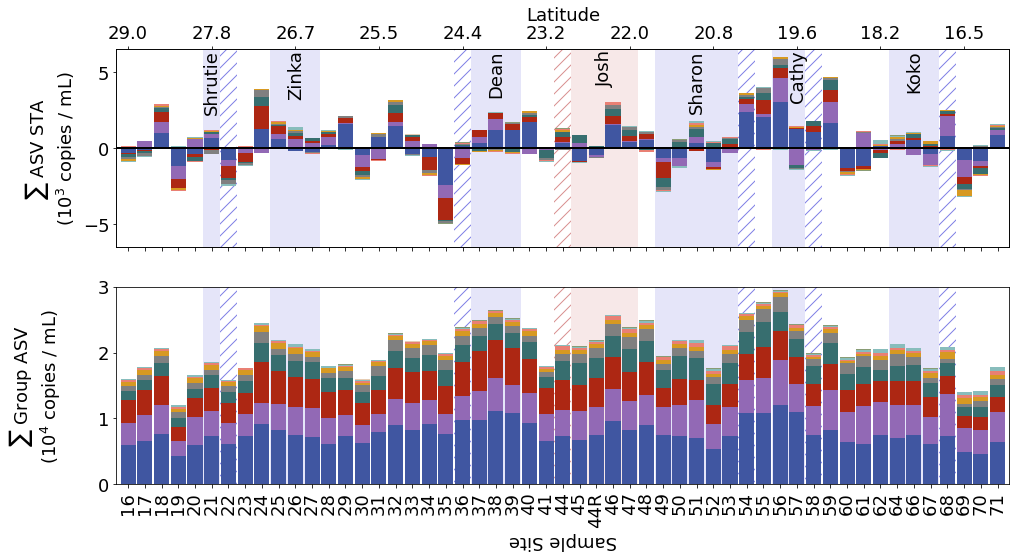

In [99]:
fig,ax = plt.subplots(2,1,figsize=(16,8))

################# STA PLOT #################
plot = euk_sum_sorted.plot(kind='bar',stacked=True,ax=ax[0],width=0.9,color=euk_group_colors)
ax[0].get_legend().remove()
ax[0].axhline(0,c='k',linewidth=2)
ax[0].set_xlabel('')

pwr = 3
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(pwr,pwr)) # Add sci notation
ax[0].yaxis.get_offset_text().set_visible(False) # Remove sci notation label
ax[0].set_ylabel('$\sum$ ASV STA\n($10^%s$ copies / mL)'%(pwr),fontsize=fontsize)


ax1 = ax[0].twiny()
ax1.set_xlim(ax[0].get_xlim())
ax1.set_xticks(np.arange(0,53,5))
ax1.set_xticklabels([str(round(i,1)) for i in metadata_df.latitude][::5])
ax1.set_xlabel('Latitude')

ymin0,ymax0 = -6500,6500
ax[0].set_ylim([ymin0,ymax0])

# Eddy labels
ax[0].text(4.5,ymax0,'Shrutie',rotation=90,verticalalignment='top')
ax[0].text(9.5,ymax0,'Zinka',rotation=90,verticalalignment='top')
ax[0].text(21.5,ymax0,'Dean',rotation=90,verticalalignment='top')
ax[0].text(28,ymax0,'Josh',rotation=90,verticalalignment='top')
ax[0].text(33.5,ymax0,'Sharon',rotation=90,verticalalignment='top')
ax[0].text(39.5,ymax0,'Cathy',rotation=90,verticalalignment='top')
ax[0].text(46.5,ymax0,'Koko',rotation=90,verticalalignment='top')

ax[0].set_xticklabels([])

################# ABUNDANCE PLOT #################

plot = euk_raw_df_sorted.plot(kind='bar',stacked=True,ax=ax[1],width=0.9,color=euk_group_colors)
ax[1].get_legend().remove()

pwr = 4
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(pwr,pwr)) # Add sci notation
ax[1].yaxis.get_offset_text().set_visible(False) # Remove sci notation label
ax[1].set_ylabel('$\sum$ Group ASV\n($10^%s$ copies / mL)'%(pwr),fontsize=fontsize,labelpad=35)

ymin1,ymax1 = 0,30000
ax[1].set_ylim([ymin1,ymax1])
ax[1].set_xlabel('Sample Site',rotation=180)


################# EDDY SHADING #################

eddy_type_dict = {'in_anti':['firebrick','x'],
                  'near_anti':['firebrick','//'],
                  'in_cyc':['mediumblue','x'],
                  'near_cyc':['mediumblue','//']}


for eddy_type,values in eddy_type_dict.items():
    eddy_ids = np.unique(metadata_df.iloc[np.where(metadata_df[eddy_type] != 0)[0]][eddy_type])
    for ID in eddy_ids:
        inds = np.where([metadata_df[eddy_type] == ID])[1]
        
        for a in ax:
            if a == ax[0]:
                ymin,ymax=ymin0,ymax0
            elif a == ax[1]:
                ymin,ymax=ymin1,ymax1
                
            if (eddy_type == 'in_anti') or (eddy_type == 'in_cyc'):
                a.fill_between([inds[0]-0.5,inds[-1]+0.5],ymin,y2=ymax, 
                                facecolor=values[0],alpha=0.1,linewidth=0)
            else:
                for i in np.arange(0,len(inds)):
                    a.fill_between([inds[i]-0.5,inds[i]+0.5],ymin,y2=ymax,hatch=values[1], 
                                facecolor='none', edgecolor=values[0],alpha=0.5,linewidth=0)


#plt.savefig(euk_paper_dir + 'figs/prelim/euk_group_STA_v3.pdf',dpi=350, bbox_inches='tight', format='pdf')
#plt.show()